# MONet FT-ICR-MS Hands-on Sesson

This script will read in the molecular formula assignments from CoreMS and plot common figures.<br>
The data is from the 1000 Soils Pilot project and has been:
- Formula assigned, filtered and aligned in Formularity format ('icr.reps.combined_v1.csv')<br>
- Summarized, averaged and merged with soil chemistry data ('Summary_Merged_ZenodoShinyAp.csv') <br>


### Before the Day 

Please run the test script "HelloWorld_test" located in the same Github folder (https://github.com/EMSL-MONet/CommSciMtg_Nov23/tree/main/FTICR) to install all necessary libraries. 
If you have any trouble please contact: 

Will Kew 
@email: william.kew@pnnl.gov

Nicole DiDonato
@email: nicole.didonato@pnnl.gov


### On the Day 

## Part I: Data Exploration using Longform 1000 Soils Data

### 1. Import necessary libraries and specify filepath

In [1]:
#Import libraries

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy as sp

### 2. Read datasets and set formating

In [2]:
#Set column orders
init_columns = ['Molecular.Formula', 'C', 'H', 'O', 'N', #'C13', 
                'S', 'P', #'Na',
                'El_comp', 'Class',#'NeutralMass',
                'Error_ppm', 
                'Candidates', 'H.C','O.C']

El_comp_order = ['CHO','CHON']

sns.set(font_scale=2)
sns.set_style("white")

#read in the longform dataset
df = pd.read_csv('data/icr.reps.combined_v1_clean.csv')

#read in the merged summary file dataset
m = pd.read_csv('data/Summary_Merged_ZenodoShinyAp.csv')


#get sample (spectrum) names
samples = list(df.columns[len(init_columns):].values)



### 3. Check data is loaded and inspect format

In [3]:
#check data is loaded and inspect format
df.shape
df

Molecular.Formula   C   H   O  N  S  P El_comp       Class  Error_ppm  \
0              C6 H8 O2   6   8   2  0  0  0     CHO      lignin   0.024394   
1             C6 H10 O2   6  10   2  0  0  0     CHO     protein   0.014727   
2              C5 H8 O3   5   8   3  0  0  0     CHO  aminosugar  -0.008562   
3              C8 H6 O1   8   6   1  0  0  0     CHO      condHC  -0.039365   
4             C5 H10 O3   5  10   3  0  0  0     CHO  aminosugar  -0.002767   
...                 ...  ..  ..  .. .. .. ..     ...         ...        ...   
13693    C46 H45 O22 N1  46  45  22  1  0  0    CHON      lignin  -0.027775   
13694       C48 H60 O21  48  60  21  0  0  0     CHO      lignin   0.082404   
13695       C46 H54 O23  46  54  23  0  0  0     CHO      lignin  -0.102030   
13696       C47 H58 O22  47  58  22  0  0  0     CHO      lignin  -0.045174   
13697       C48 H62 O21  48  62  21  0  0  0     CHO      lignin  -0.151223   

       ...  UT32_BTM  KONA_BTM  SERC_BTM  UT19_TOP  TEAK_BTM  MOAB_BTM  \
0      ...         0         0         0         0         0         0   
1      ...         0         0         0         0         0         0   
2      ...         0         0         0         0         0         0   
3      ...         0         0         0         0         0         0   
4      ...         0         0         1         0         1         0   
...    ...       ...       ...       ...       ...       ...       ...   
13693  ...         0         0         1         0         0         0   
13694  ...         0         0         0         0         0         0   
13695  ...         0         0         1         0         0         0   
13696  ...         0         0         0         0         0         0   
13697  ...         0         0         0         0         0         0   

       SOAP_BTM  WY09_TOP  OKPF_TOP  WY09_BTM  
0             0         0         0         0  
1             0         0         0         0  
2             0         0         0         0  
3             0         0         0         0  
4             0         0         0         1  
...         ...       ...       ...       ...  
13693         0         0         0         1  
13694         0         0         0         0  
13695         0         0         0         0  
13696         0         0         0         0  
13697         0         0         0         0  

[13698 rows x 137 columns]

### 4. Calculate properties for each molecular formula 

In [4]:
#define equations and calculate molecular properties:

#Aromaticity Index calculation. Unlike DBE, this factors in O and S. Taken from DOI: 10.1002/rcm.2386 
#(correction at https://doi.org/10.1002/rcm.7433)
def AIcalc(C,H,N,O,S):#remove P
    top = 1+C-O-S-(0.5*(H+N)) #corrected from 1/2 H only (0.5*H) per https://doi.org/10.1002/rcm.7433
    btm = C-O-S-N  #remove P
    if btm == 0:
        AI = 0
    else:
        AI = top/btm
    if AI < 0:
        AI = 0
    return AI

#AImod assumes half of the oxygens do not contribute to aromaticity. 
#e.g. O bonded to carboxylic acid. Same reference as above.
def AImodcalc(C,H,N,O,S):#remove P
    O = O/2
    top = 1+C-O-S-(0.5*(H+N)) #corrected from 1/2 H only (0.5*H) per https://doi.org/10.1002/rcm.7433
    btm = C-O-S-N#remove P
    if btm == 0:
        AI = 0
    else:
        AI = top/btm
    if AI < 0:
        AI = 0
    return AI

def DBEcalc(C,H,N):#original DBE calculation, includes double bonds from heteroatoms- independent of O
    return 1+(0.5*(2*C-H+N))#remove P

def DBEcalcAI(C,O,H,N,S):#subtracts all heteroatom double bonds as not contributing to aromaticity (rings or condensation)
    return 1+C-O-S-0.5*(N+H)#remove P

def MolForm(C,H,O,N):
    MF ='C' + str(C) + 'H' + str(H) + 'O' + str(O) + 'N' + str(N) #+ 'C13' + str(C13) #remove C13 for MONet
    return MF

def NOSCcalc(C,H,O,N,S): #remove P
    NOSCtop = 4*C + H - 3*N - 2*O - 2*S  #remove P
    NOSCbtm = C
    if NOSCbtm == 0:
        NOSC = 0
    else: 
        NOSC = -(NOSCtop/NOSCbtm) + 4  #NOSC = -((4*C + H - 3*N - 2*O + 5*P - 2*S)/(C)) + 4
    return NOSC


#see DOI  10.1016/j.gca.2011.01.020
def GFEcalc(NOSC): 
    GFE_cox = 60.3 - 28.5*(NOSC)
    return GFE_cox

# here we will calculate DBE, AI, and AImod, NOSC, and GFE
for index,data in df.iterrows():
    C = data['C']
    H = data['H']
    N = data['N']
    O = data['O']
    S = data['S']
    df.loc[index,'DBE'] = DBEcalc(C,H,N)
    df.loc[index,'AI'] = AIcalc(C,H,N,O,S)
    df.loc[index,'AImod'] = AImodcalc(C,H,N,O,S)
    df.loc[index, 'MF'] = MolForm(C,H,O,N)
    df.loc[index, 'NOSC'] = NOSCcalc(C,H,O,N,S)
    df.loc[index, 'GFE_cox'] = GFEcalc(NOSCcalc(C,H,O,N,S))   

#calculate the OC and HC ratios
df['O/C'] = df['O']/df['C']
df['H/C'] = df['H']/df['C']

In [5]:
# inspect df
df

Molecular.Formula   C   H   O  N  S  P El_comp       Class  Error_ppm  \
0              C6 H8 O2   6   8   2  0  0  0     CHO      lignin   0.024394   
1             C6 H10 O2   6  10   2  0  0  0     CHO     protein   0.014727   
2              C5 H8 O3   5   8   3  0  0  0     CHO  aminosugar  -0.008562   
3              C8 H6 O1   8   6   1  0  0  0     CHO      condHC  -0.039365   
4             C5 H10 O3   5  10   3  0  0  0     CHO  aminosugar  -0.002767   
...                 ...  ..  ..  .. .. .. ..     ...         ...        ...   
13693    C46 H45 O22 N1  46  45  22  1  0  0    CHON      lignin  -0.027775   
13694       C48 H60 O21  48  60  21  0  0  0     CHO      lignin   0.082404   
13695       C46 H54 O23  46  54  23  0  0  0     CHO      lignin  -0.102030   
13696       C47 H58 O22  47  58  22  0  0  0     CHO      lignin  -0.045174   
13697       C48 H62 O21  48  62  21  0  0  0     CHO      lignin  -0.151223   

       ...  OKPF_TOP  WY09_BTM   DBE        AI     AImod           MF  \
0      ...         0         0   3.0  0.250000  0.400000     C6H8O2N0   
1      ...         0         0   2.0  0.000000  0.200000    C6H10O2N0   
2      ...         0         0   2.0  0.000000  0.142857     C5H8O3N0   
3      ...         0         0   6.0  0.714286  0.733333     C8H6O1N0   
4      ...         0         1   1.0  0.000000  0.000000    C5H10O3N0   
...    ...       ...       ...   ...       ...       ...          ...   
13693  ...         0         1  25.0  0.086957  0.382353  C46H45O22N1   
13694  ...         0         0  19.0  0.000000  0.226667  C48H60O21N0   
13695  ...         0         0  20.0  0.000000  0.246377  C46H54O23N0   
13696  ...         0         0  19.0  0.000000  0.222222  C47H58O22N0   
13697  ...         0         0  18.0  0.000000  0.200000  C48H62O21N0   

           NOSC    GFE_cox       O/C       H/C  
0     -0.666667  79.300000  0.333333  1.333333  
1     -1.000000  88.800000  0.333333  1.666667  
2     -0.400000  71.700000  0.600000  1.600000  
3     -0.500000  74.550000  0.125000  0.750000  
4     -0.800000  83.100000  0.600000  2.000000  
...         ...        ...       ...       ...  
13693  0.043478  59.060870  0.478261  0.978261  
13694 -0.375000  70.987500  0.437500  1.250000  
13695 -0.173913  65.256522  0.500000  1.173913  
13696 -0.297872  68.789362  0.468085  1.234043  
13697 -0.416667  72.175000  0.437500  1.291667  

[13698 rows x 145 columns]

In [6]:
#transpose data to long form in order to make plots

id_vars = init_columns + ['DBE','AI','AImod','MF','NOSC', 'GFE_cox','O/C','H/C']
value_vars = samples 
df = pd.melt(df,id_vars = id_vars,
                       value_vars = value_vars,
                       var_name='Sample',
                       value_name = 'Intensity')

In [7]:
#inspect df
df

Molecular.Formula   C   H   O  N  S  P El_comp       Class  Error_ppm  \
0                C6 H8 O2   6   8   2  0  0  0     CHO      lignin   0.024394   
1               C6 H10 O2   6  10   2  0  0  0     CHO     protein   0.014727   
2                C5 H8 O3   5   8   3  0  0  0     CHO  aminosugar  -0.008562   
3                C8 H6 O1   8   6   1  0  0  0     CHO      condHC  -0.039365   
4               C5 H10 O3   5  10   3  0  0  0     CHO  aminosugar  -0.002767   
...                   ...  ..  ..  .. .. .. ..     ...         ...        ...   
1698547    C46 H45 O22 N1  46  45  22  1  0  0    CHON      lignin  -0.027775   
1698548       C48 H60 O21  48  60  21  0  0  0     CHO      lignin   0.082404   
1698549       C46 H54 O23  46  54  23  0  0  0     CHO      lignin  -0.102030   
1698550       C47 H58 O22  47  58  22  0  0  0     CHO      lignin  -0.045174   
1698551       C48 H62 O21  48  62  21  0  0  0     CHO      lignin  -0.151223   

         ...   DBE        AI     AImod           MF      NOSC    GFE_cox  \
0        ...   3.0  0.250000  0.400000     C6H8O2N0 -0.666667  79.300000   
1        ...   2.0  0.000000  0.200000    C6H10O2N0 -1.000000  88.800000   
2        ...   2.0  0.000000  0.142857     C5H8O3N0 -0.400000  71.700000   
3        ...   6.0  0.714286  0.733333     C8H6O1N0 -0.500000  74.550000   
4        ...   1.0  0.000000  0.000000    C5H10O3N0 -0.800000  83.100000   
...      ...   ...       ...       ...          ...       ...        ...   
1698547  ...  25.0  0.086957  0.382353  C46H45O22N1  0.043478  59.060870   
1698548  ...  19.0  0.000000  0.226667  C48H60O21N0 -0.375000  70.987500   
1698549  ...  20.0  0.000000  0.246377  C46H54O23N0 -0.173913  65.256522   
1698550  ...  19.0  0.000000  0.222222  C47H58O22N0 -0.297872  68.789362   
1698551  ...  18.0  0.000000  0.200000  C48H62O21N0 -0.416667  72.175000   

              O/C       H/C    Sample  Intensity  
0        0.333333  1.333333  CFS1_TOP          0  
1        0.333333  1.666667  CFS1_TOP          0  
2        0.600000  1.600000  CFS1_TOP          0  
3        0.125000  0.750000  CFS1_TOP          0  
4        0.600000  2.000000  CFS1_TOP          0  
...           ...       ...       ...        ...  
1698547  0.478261  0.978261  WY09_BTM          1  
1698548  0.437500  1.250000  WY09_BTM          0  
1698549  0.500000  1.173913  WY09_BTM          0  
1698550  0.468085  1.234043  WY09_BTM          0  
1698551  0.437500  1.291667  WY09_BTM          0  

[1698552 rows x 23 columns]

In [7]:
# clean up by dropping rows where a peak was not found in a given sample(i.e. zero intensity)
print(df.shape)
df = df[df['Intensity']!=0.0]
print(df.shape)

(1698552, 23)
(607468, 23)


In [8]:
# make new columns for each sample site and depth (top or bottom)
df[['Site','Depth']] = df['Sample'].str.split('_', expand=True)

In [9]:
# assign biome types

biome_dict = {# 'Desert_XericShrubland'
'ANZA': 'Desert_Shrubland',
'FTA3': 'Desert_Shrubland',
'FTA5': 'Desert_Shrubland',
'JORN': 'Desert_Shrubland',
'MOAB': 'Desert_Shrubland',
'OCTB': 'Desert_Shrubland',
'OCTU': 'Desert_Shrubland',
'ONAQ': 'Desert_Shrubland',
'PRS2': 'Desert_Shrubland',
'SRER': 'Desert_Shrubland',
'SRR1': 'Desert_Shrubland',
'UT32': 'Desert_Shrubland',
# PUUM #missing from FTICRMS

#'MediterraneanForests_Woodlands_Scrub'
'SJER': 'Medit_Woodlands',

# : 'Temperate_Broadleaf_&_Mixed Forests'
'BLAN': 'Temp_Forests', 
'CFS2': 'Temp_Forests', 
'DELA': 'Temp_Forests', 
'GRSM': 'Temp_Forests',  
'LENO': 'Temp_Forests', 
'MLBS': 'Temp_Forests',  
'NWBA': 'Temp_Forests',
'NWBB': 'Temp_Forests',
'NWBC': 'Temp_Forests', 
'ORNL': 'Temp_Forests', 
'PPRH': 'Temp_Forests', 
'PRS1': 'Temp_Forests',
'SCBI': 'Temp_Forests',
'SERC': 'Temp_Forests',
'TALL': 'Temp_Forests', 
'WLLO': 'Temp_Forests', 
'WLUP': 'Temp_Forests', 
# HARV #missing from FTICRMS
# STEI #missing from FTICRMS
# TREE #missing from FTICRMS


# Temperate_Conifer_Forests
'CFS1': 'Temp_Conif_Forests', 
'DSNY': 'Temp_Conif_Forests',
'JERC': 'Temp_Conif_Forests',
'OKPF': 'Temp_Conif_Forests',
'OSBS': 'Temp_Conif_Forests',
'PETF': 'Temp_Conif_Forests',
'PHTU': 'Temp_Conif_Forests',
'RMNP': 'Temp_Conif_Forests',
'SOAP': 'Temp_Conif_Forests',
'UT12': 'Temp_Conif_Forests',
'UT19': 'Temp_Conif_Forests',
'UT23': 'Temp_Conif_Forests',
'UT24': 'Temp_Conif_Forests',
'WY01': 'Temp_Conif_Forests',
'WY03': 'Temp_Conif_Forests',
'WY09': 'Temp_Conif_Forests',
'WY10': 'Temp_Conif_Forests',
'WY15': 'Temp_Conif_Forests',
# NIWO #missing from FTICRMS


# Temperate_Grasslands_Savannas_Shrublands
'CLBJ': 'Temp_Grasslands',
'CPER': 'Temp_Grasslands',
'DCFS': 'Temp_Grasslands',
'ISCC': 'Temp_Grasslands',
'ISNC': 'Temp_Grasslands',
'KONA': 'Temp_Grasslands',
'KONZ': 'Temp_Grasslands',
'NOGP': 'Temp_Grasslands',
'UKFS': 'Temp_Grasslands',
# WOOD #missing from ICRMS
}

df['BiomeType'] = df['Site'].map(biome_dict)

In [10]:
df

Molecular.Formula   C   H   O  N  S  P El_comp   Class  Error_ppm  \
6                C7 H6 O2   7   6   2  0  0  0     CHO  lignin  -0.026546   
9                C7 H8 O2   7   8   2  0  0  0     CHO  lignin  -0.027085   
12              C7 H10 O2   7  10   2  0  0  0     CHO  lignin   0.013212   
15               C6 H8 O3   6   8   3  0  0  0     CHO  lignin  -0.051096   
16              C7 H12 O2   7  12   2  0  0  0     CHO   lipid  -0.047839   
...                   ...  ..  ..  .. .. .. ..     ...     ...        ...   
1698392       C38 H26 O23  38  26  23  0  0  0     CHO  condHC   0.230369   
1698402       C38 H32 O23  38  32  23  0  0  0     CHO  lignin   0.120008   
1698417       C38 H34 O23  38  34  23  0  0  0     CHO  lignin  -0.190439   
1698427       C39 H26 O23  39  26  23  0  0  0     CHO  condHC  -0.170176   
1698547    C46 H45 O22 N1  46  45  22  1  0  0    CHON  lignin  -0.027775   

         ...           MF      NOSC    GFE_cox       O/C       H/C    Sample  \
6        ...     C7H6O2N0 -0.285714  68.442857  0.285714  0.857143  CFS1_TOP   
9        ...     C7H8O2N0 -0.571429  76.585714  0.285714  1.142857  CFS1_TOP   
12       ...    C7H10O2N0 -0.857143  84.728571  0.285714  1.428571  CFS1_TOP   
15       ...     C6H8O3N0 -0.333333  69.800000  0.500000  1.333333  CFS1_TOP   
16       ...    C7H12O2N0 -1.142857  92.871429  0.285714  1.714286  CFS1_TOP   
...      ...          ...       ...        ...       ...       ...       ...   
1698392  ...  C38H26O23N0  0.526316  45.300000  0.605263  0.684211  WY09_BTM   
1698402  ...  C38H32O23N0  0.368421  49.800000  0.605263  0.842105  WY09_BTM   
1698417  ...  C38H34O23N0  0.315789  51.300000  0.605263  0.894737  WY09_BTM   
1698427  ...  C39H26O23N0  0.512821  45.684615  0.589744  0.666667  WY09_BTM   
1698547  ...  C46H45O22N1  0.043478  59.060870  0.478261  0.978261  WY09_BTM   

        Intensity  Site  Depth           BiomeType  
6               1  CFS1    TOP  Temp_Conif_Forests  
9               1  CFS1    TOP  Temp_Conif_Forests  
12              1  CFS1    TOP  Temp_Conif_Forests  
15              1  CFS1    TOP  Temp_Conif_Forests  
16              1  CFS1    TOP  Temp_Conif_Forests  
...           ...   ...    ...                 ...  
1698392         1  WY09    BTM  Temp_Conif_Forests  
1698402         1  WY09    BTM  Temp_Conif_Forests  
1698417         1  WY09    BTM  Temp_Conif_Forests  
1698427         1  WY09    BTM  Temp_Conif_Forests  
1698547         1  WY09    BTM  Temp_Conif_Forests  

[607468 rows x 26 columns]

#### Check list of samples and range of data for several useful columns

In [11]:
#list of samples
list = df['Sample'].unique()
list.sort()
list

array(['ANZA_BTM', 'ANZA_TOP', 'BLAN_BTM', 'BLAN_TOP', 'CFS1_BTM',
       'CFS1_TOP', 'CFS2_BTM', 'CFS2_TOP', 'CLBJ_BTM', 'CLBJ_TOP',
       'CPER_TOP', 'DCFS_BTM', 'DCFS_TOP', 'DELA_BTM', 'DELA_TOP',
       'DSNY_BTM', 'DSNY_TOP', 'FTA3_BTM', 'FTA3_TOP', 'FTA5_BTM',
       'FTA5_TOP', 'GRSM_BTM', 'GRSM_TOP', 'ISCC_BTM', 'ISCC_TOP',
       'ISNC_BTM', 'ISNC_TOP', 'JERC_BTM', 'JERC_TOP', 'JORN_BTM',
       'JORN_TOP', 'KONA_BTM', 'KONA_TOP', 'KONZ_BTM', 'KONZ_TOP',
       'LENO_BTM', 'LENO_TOP', 'MLBS_BTM', 'MLBS_TOP', 'MOAB_BTM',
       'MOAB_TOP', 'NOGP_BTM', 'NOGP_TOP', 'NWBA_BTM', 'NWBA_TOP',
       'NWBB_BTM', 'NWBB_TOP', 'NWBC_BTM', 'NWBC_TOP', 'OAES_BTM',
       'OAES_TOP', 'OCTB_BTM', 'OCTB_TOP', 'OCTU_BTM', 'OCTU_TOP',
       'OKPF_BTM', 'OKPF_TOP', 'ONAQ_BTM', 'ONAQ_TOP', 'ORNL_BTM',
       'ORNL_TOP', 'OSBS_BTM', 'OSBS_TOP', 'PETF_BTM', 'PETF_TOP',
       'PHTU_BTM', 'PHTU_TOP', 'PPRH_BTM', 'PPRH_TOP', 'PRS1_BTM',
       'PRS1_TOP', 'PRS2_BTM', 'PRS2_TOP', 'RMNP_BTM', 'RMNP_T

In [12]:
df['El_comp'].unique()

array(['CHO', 'CHON'], dtype=object)

In [13]:
df['N'].unique()

array([0, 1, 2], dtype=int64)

In [14]:
df['Class'].unique()

array(['lignin', 'lipid', 'tannin', 'protein', 'carb', 'condHC',
       'aminosugar', 'undefined', 'unsatHC'], dtype=object)

In [15]:
df['Depth'].unique()

array(['TOP', 'BTM'], dtype=object)

In [16]:
df['BiomeType'].unique()
#note: WSU1-3, TEAK, STER and OEAS do not have associated Biome Names listed in ShinyAp data; ok for this exercise

array(['Temp_Conif_Forests', nan, 'Desert_Shrubland', 'Temp_Forests',
       'Temp_Grasslands', 'Medit_Woodlands'], dtype=object)

### 4. Plot van Krevelen Diagrams 

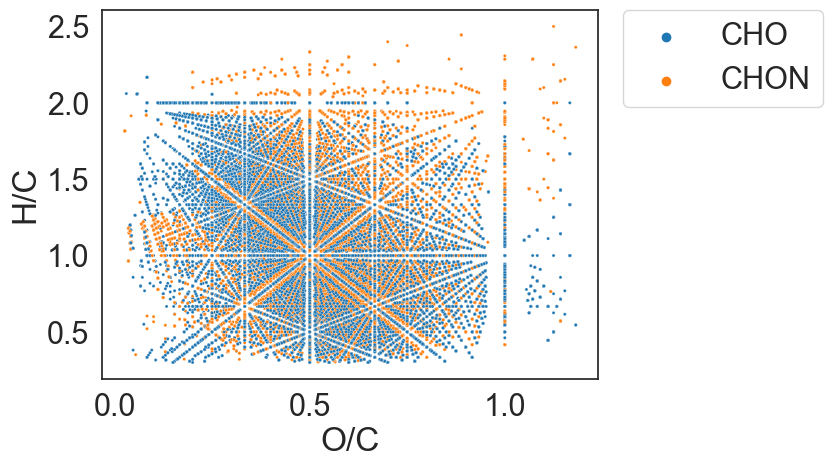

In [17]:
#vk of all formulas in all samples colored by elemental composition

ax = sns.scatterplot(df, 
                     x = 'O/C', y = "H/C", hue_order = ('CHO', 'CHON'),hue = 'El_comp', s= 5,
                    palette = "tab10")
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

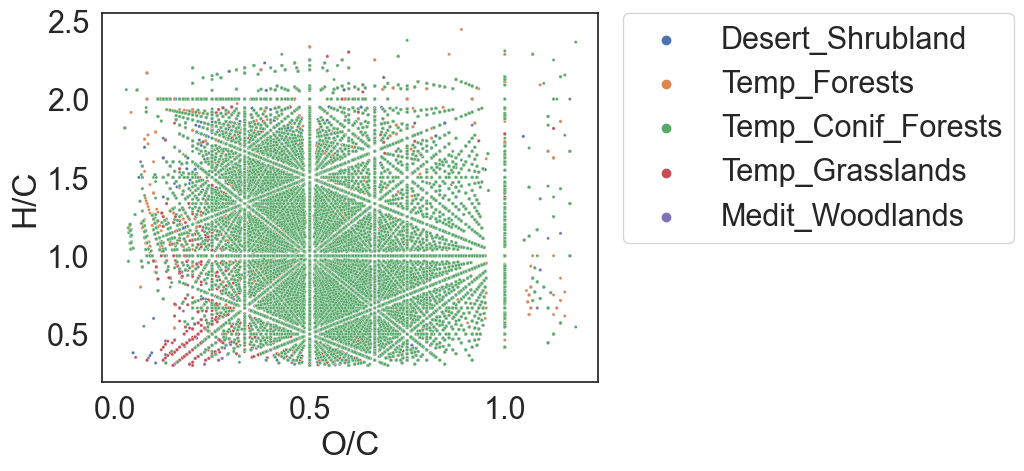

In [18]:
#vk of all formulas in all samples colored by biome type

ax = sns.scatterplot(df, 
                     x = 'O/C', y = "H/C", 
                     hue_order = ('Desert_Shrubland', 'Temp_Forests', 'Temp_Conif_Forests',
                     'Temp_Grasslands','Medit_Woodlands'),
                     hue = 'BiomeType', s= 5)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

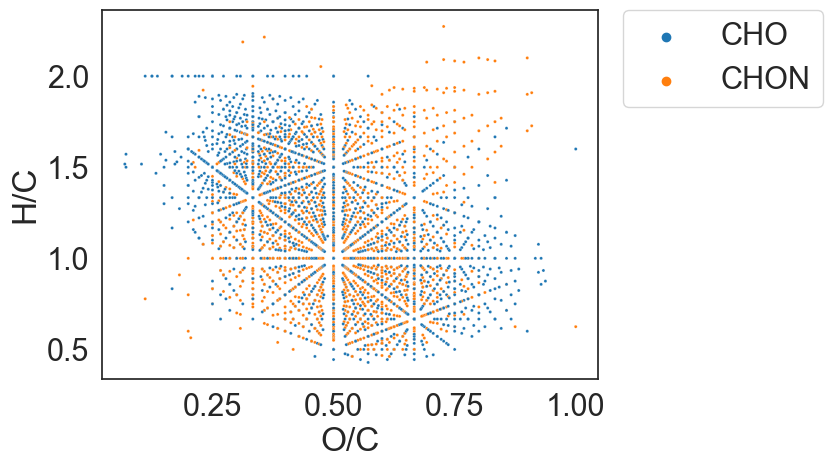

In [23]:
#vk of individual sample colored by elemental composition (select prefered site/sample from sample list above)

ax = sns.scatterplot(df[(df['Site']=='CFS1') & (df['Depth']=='TOP')], palette = "tab10",
                     x = 'O/C', y = "H/C", hue_order = ('CHO', 'CHON'),hue = 'El_comp', s= 5)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

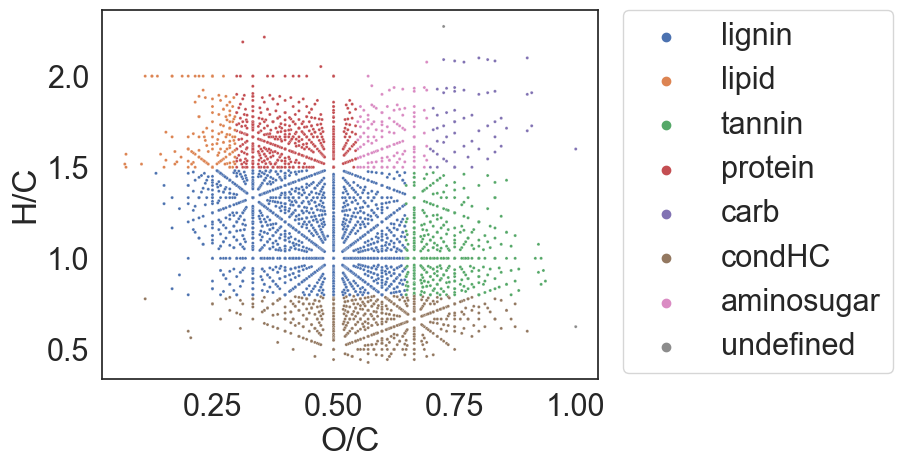

In [19]:
#vk of individual sample colored by class composition

ax = sns.scatterplot(df[(df['Site']=='CFS1') & (df['Depth']=='TOP')], 
                     x = 'O/C', y = "H/C", 
#                      hue_order = ('CHO', 'CHON'),
                     hue = 'Class', s= 5)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

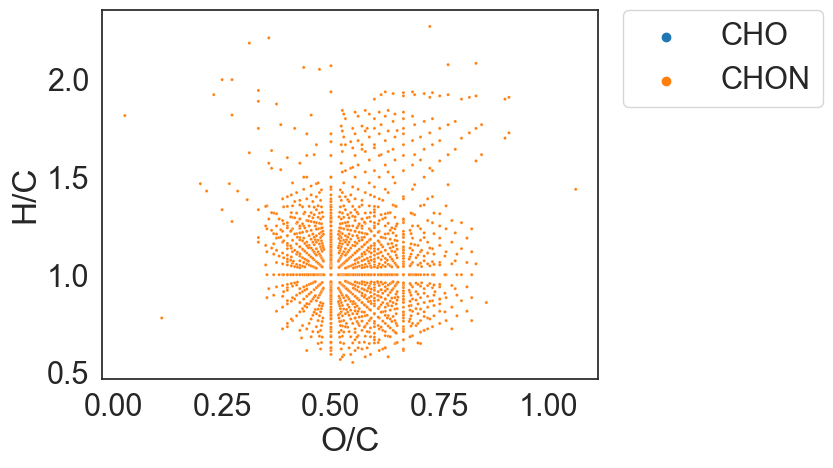

In [20]:
#vk of individual sample for only one elemental type

ax = sns.scatterplot(df[(df['Site']=='CFS1') & (df['Depth']=='BTM') & (df['El_comp'] == 'CHON')], 
                     palette = "tab10",
                     x = 'O/C', y = "H/C", hue_order = ('CHO', 'CHON'),hue = 'El_comp', s= 5)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

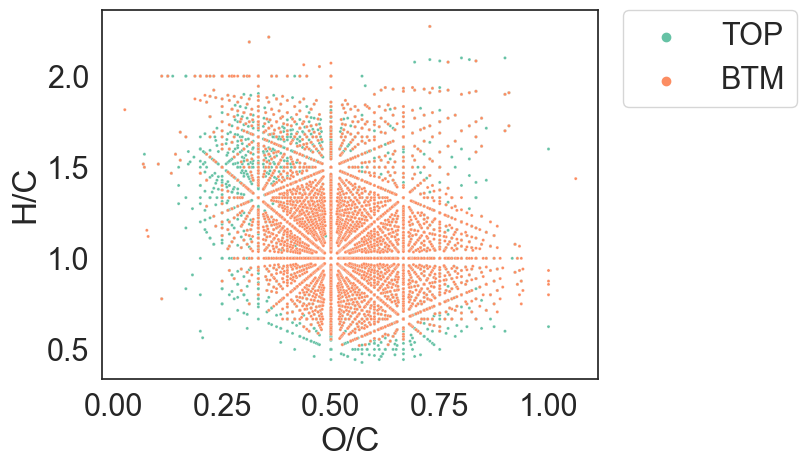

In [21]:
# vk for 2 samples (top/bottom of core)

ax = sns.scatterplot(df[(df['Site']=='CFS1')], 
                     x = 'O/C', y = "H/C", #hue_order = ('CHO', 'CHON'),
                     hue = 'Depth', 
                     palette = "Set2", 
                     s= 5)#, kind ="kde",
#                  fill = False)

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

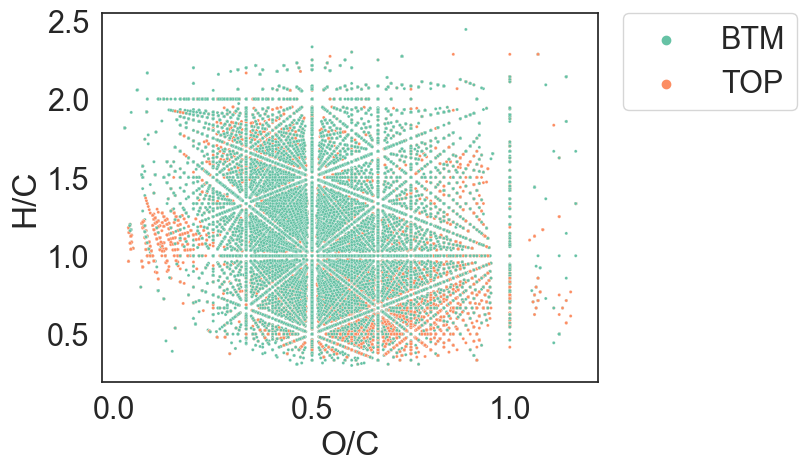

In [22]:
# vk for all samples in a BiomeType (top/bottom of core)

ax = sns.scatterplot(df[(df['BiomeType']=='Temp_Forests')], 
                     x = 'O/C', y = "H/C", #hue_order = ('CHO', 'CHON'),
                     hue = 'Depth', 
                     palette = "Set2", 
                     s= 5)#, kind ="kde",
#                  fill = False)

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

### Compare van Krevelen plots across samples by Biome Type

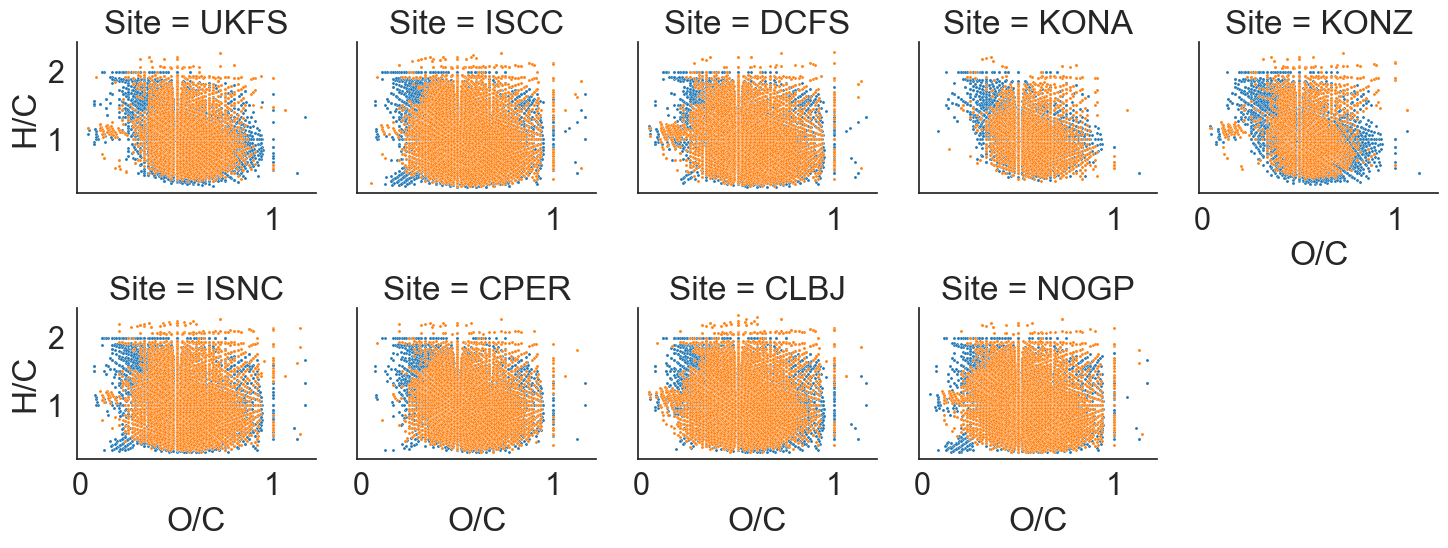

In [23]:
g = sns.FacetGrid(df[(df['BiomeType']=='Temp_Grasslands')], col="Site", palette = 'tab10',
                               col_wrap = 5, hue_order = ('CHO', 'CHON'), hue = "El_comp")
g.map_dataframe(sns.scatterplot, x="O/C", y="H/C", s = 5)

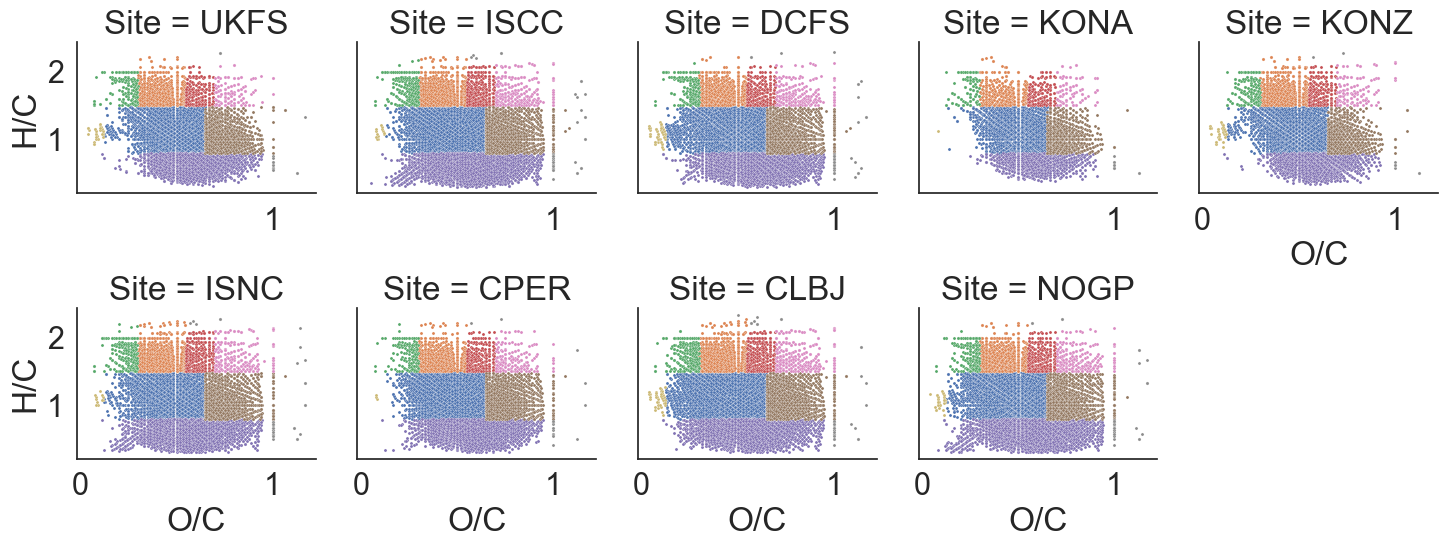

In [26]:
g = sns.FacetGrid(df[(df['BiomeType']=='Temp_Grasslands')], col="Site", 
                               col_wrap = 5,  hue = "Class")
g.map_dataframe(sns.scatterplot, x="O/C", y="H/C", s = 5)


### 5. Plot formula error 

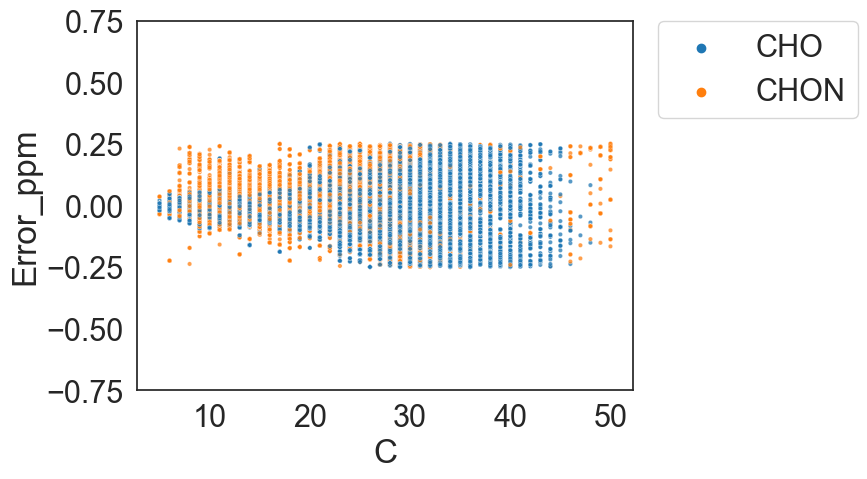

In [27]:
#Plot formula error for all formulas

sns.scatterplot(x='C',y='Error_ppm', palette = 'tab10',
                alpha=0.75,s=10,hue='El_comp',
                data=df,linewidths=0)
plt.ylim(-0.75, 0.75)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)


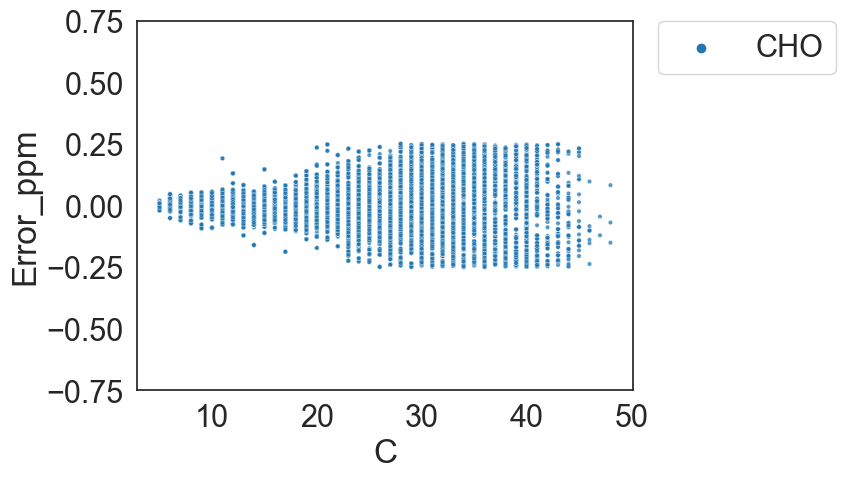

In [28]:
#Plot formula error for CHO formulas only
sns.scatterplot(x='C',y='Error_ppm',
                alpha=0.75,s=10,hue='El_comp', palette = 'tab10',#hue_order=El_comp_order,
                data=df[df['El_comp'] == 'CHO'],linewidths=0)
plt.ylim(-0.75, 0.75)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

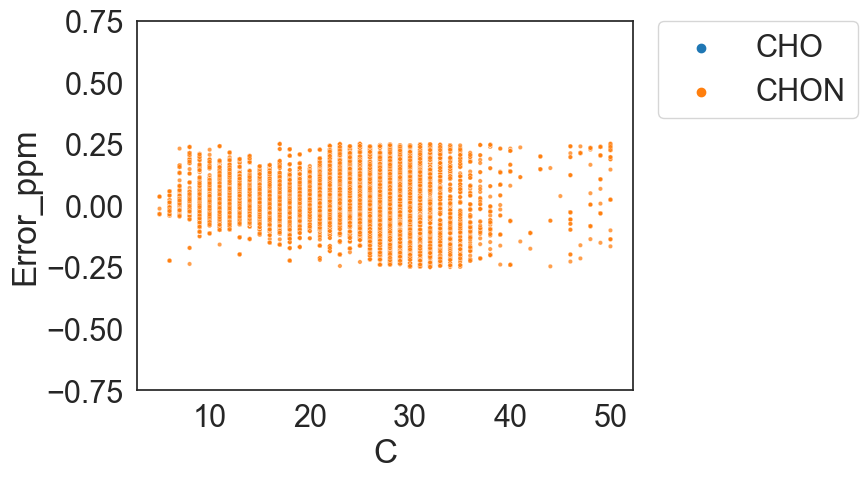

In [29]:
#Plot formula error for CHON forumulas only

sns.scatterplot(x='C',y='Error_ppm',
                alpha=0.75,s=10,hue='El_comp',palette = 'tab10',hue_order=El_comp_order,
                data=df[df['El_comp'] == 'CHON'],linewidths=0)
plt.ylim(-0.75, 0.75)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

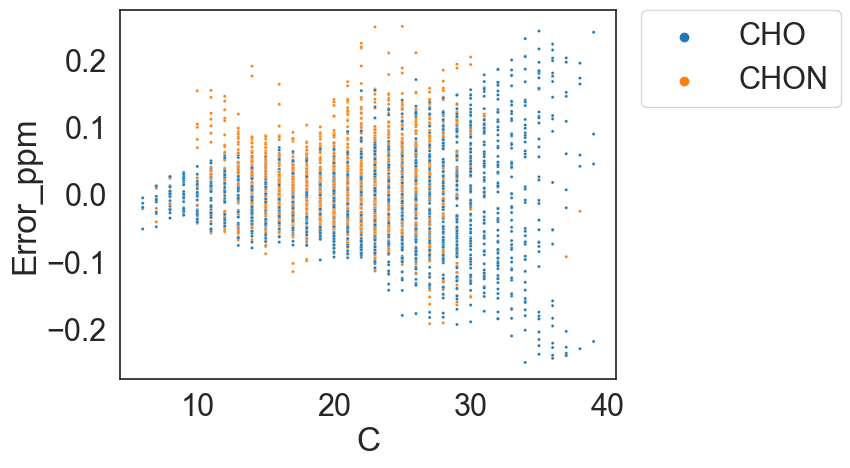

In [30]:
# Plot error distribution for an individual sample by elemental composition

ax = sns.scatterplot(df[(df['Site']=='CFS1') & (df['Depth']=='BTM')], 
                     x = 'C', y = "Error_ppm", hue_order = ['CHO', 'CHON'],
                     hue = 'El_comp',palette = 'tab10',
                     s= 5)

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Compare formula error across samples by Biome Type

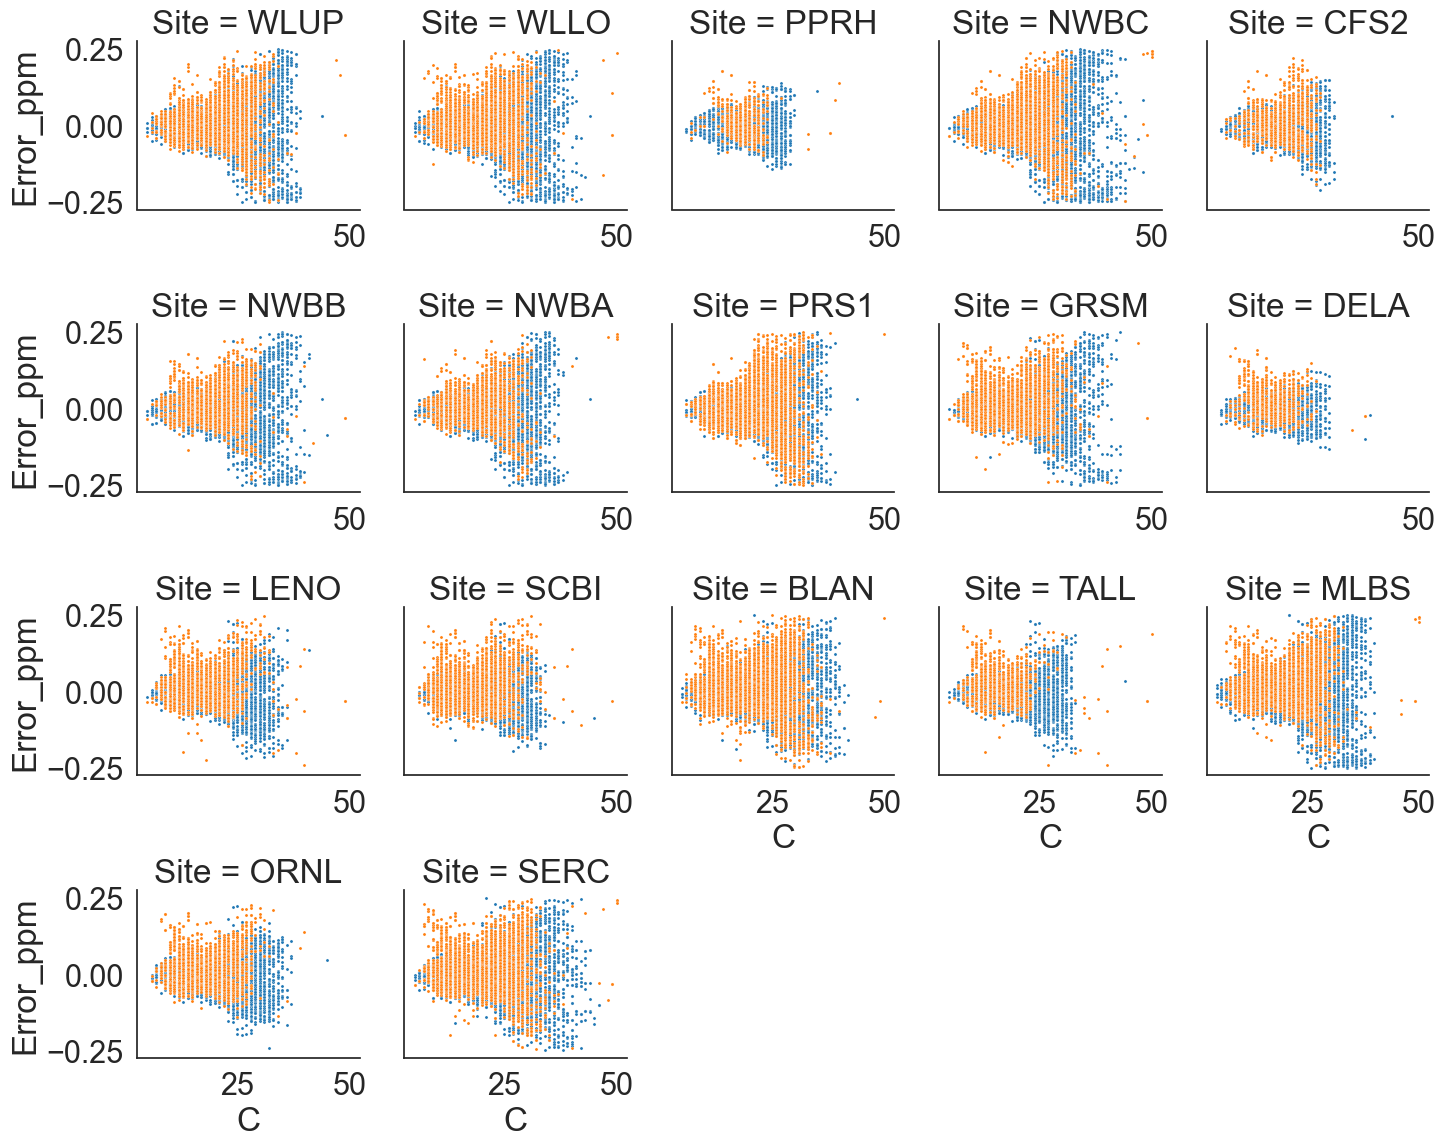

In [31]:
g = sns.FacetGrid(df[(df['BiomeType']=='Temp_Forests')], palette = 'tab10',
                  col="Site", col_wrap = 5, hue_order = ('CHO', 'CHON'), hue = "El_comp")
g.map_dataframe(sns.scatterplot, x="C", y="Error_ppm", s = 5)

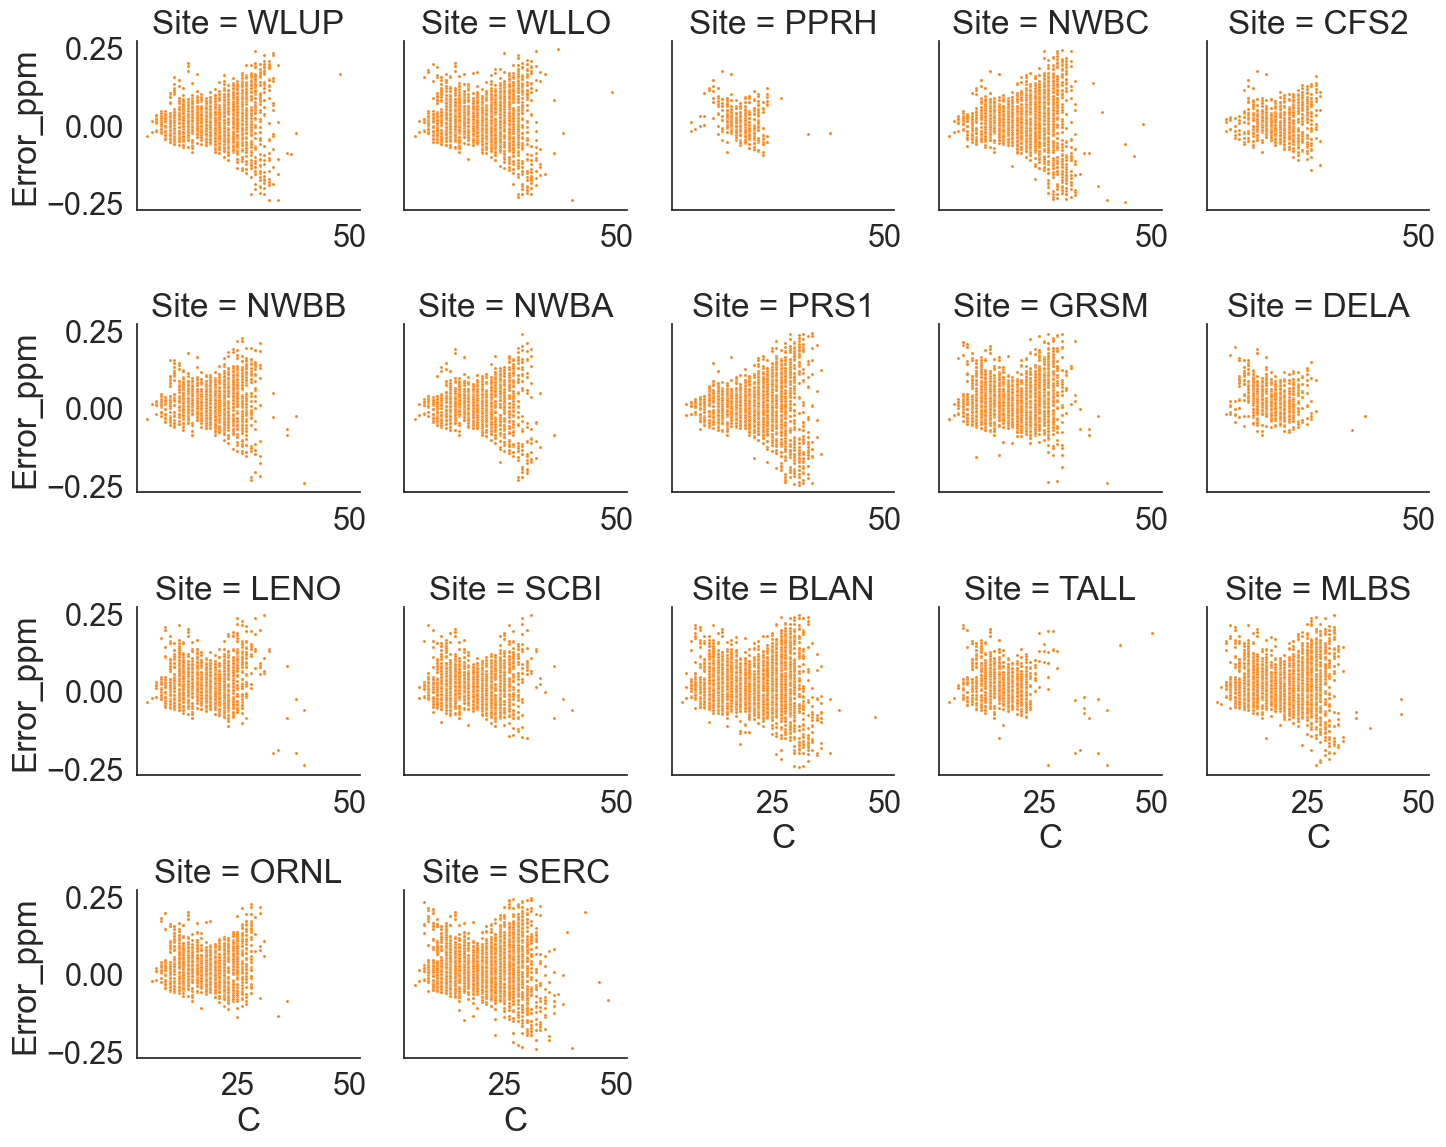

In [32]:
#CHON only

g = sns.FacetGrid(df[(df['BiomeType']=='Temp_Forests') &
                         (df['N'] == 1)], col="Site", palette = 'tab10',
                               col_wrap = 5, hue_order = ('CHO', 'CHON'), hue = "El_comp")
g.map_dataframe(sns.scatterplot, x="C", y="Error_ppm", s = 5)

### 6. Plot DBE vs C

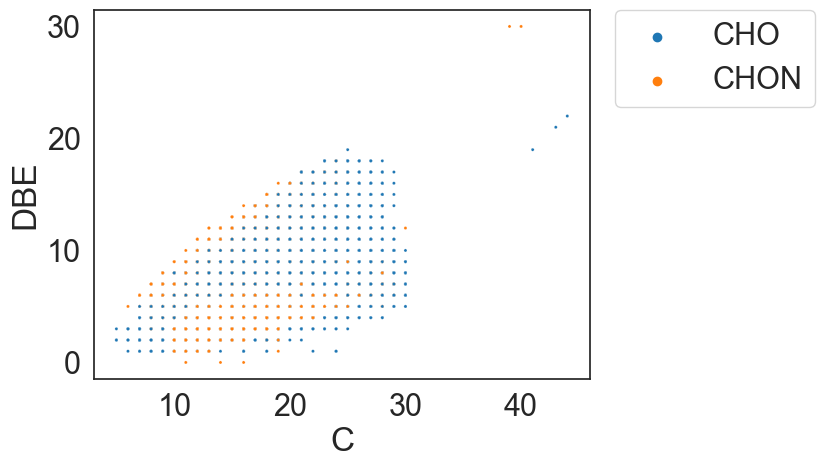

In [37]:
ax = sns.scatterplot(df[(df['Site']=='CFS1') & (df['Depth']=='TOP')], 
                     x = 'C', y = "DBE", 
                     hue = 'El_comp', palette = "tab10", s= 5)

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#### Compare DBE across samples by Biome Type

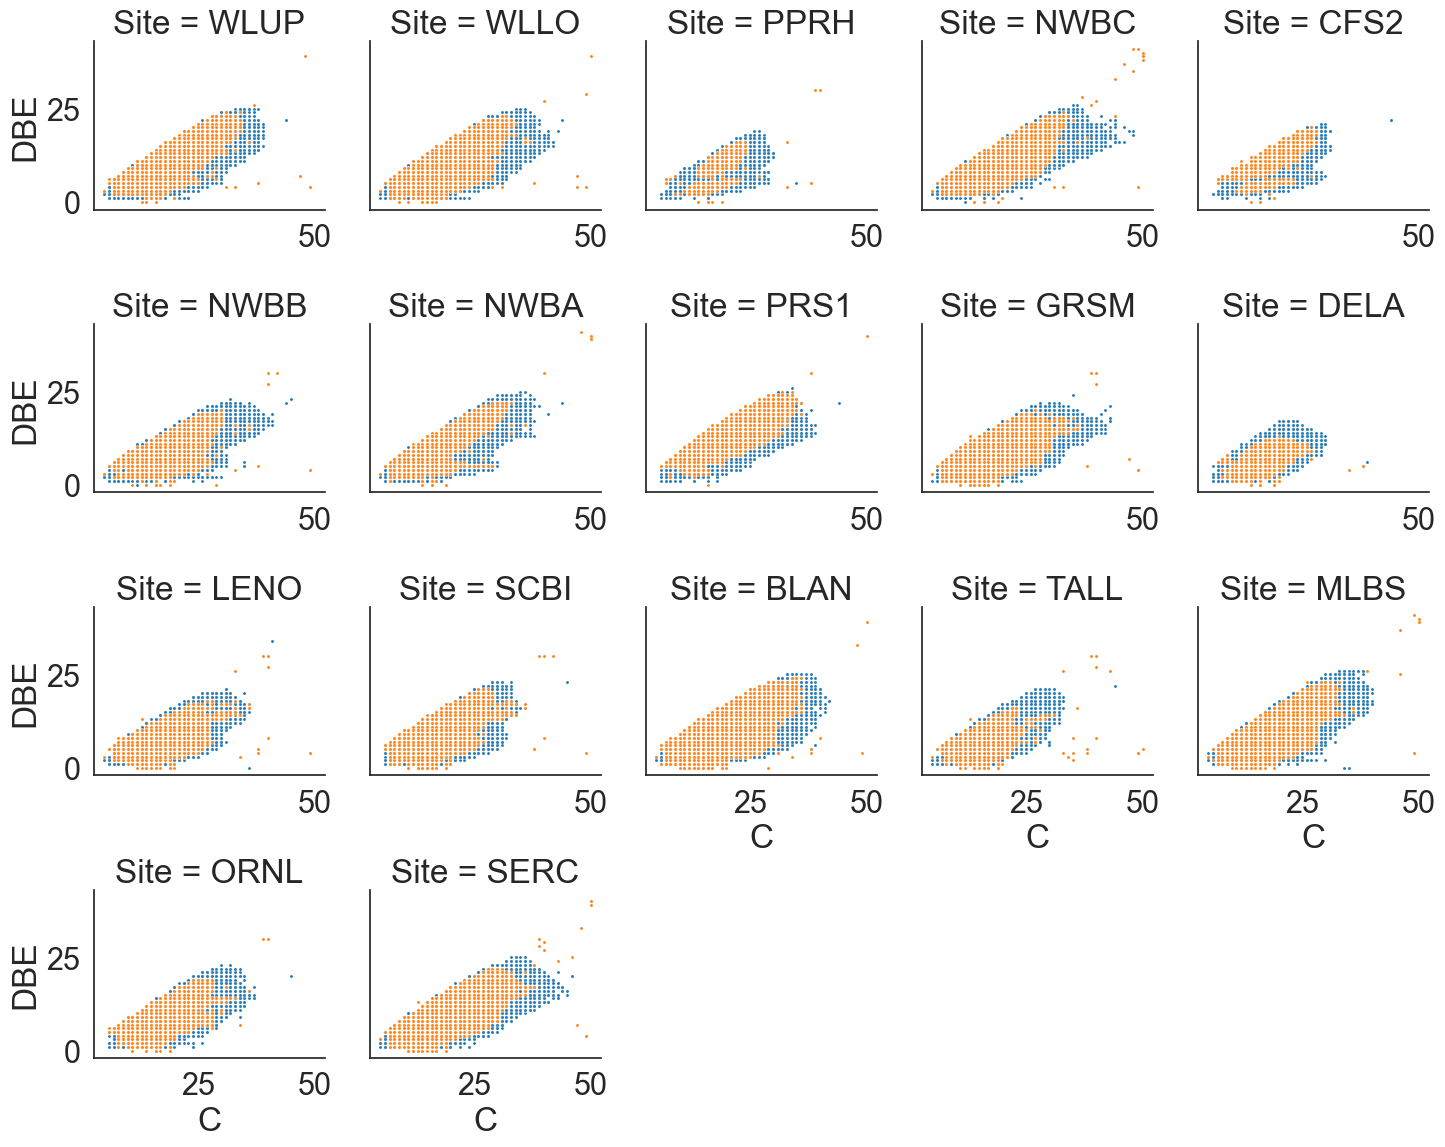

In [38]:
g = sns.FacetGrid(df[df['BiomeType']=='Temp_Forests'], col="Site", palette = 'tab10',
                               col_wrap = 5, hue_order = ('CHO', 'CHON'), hue = "El_comp")
g.map_dataframe(sns.scatterplot, x="C", y="DBE", s = 5)

### 7. Compare distribution of calculated properties by sample/type

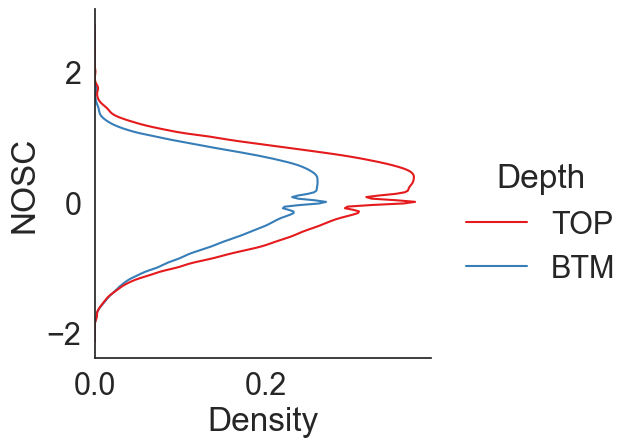

In [39]:
# NOSC values for all formulas in all samples by depth

ax = sns.displot(df, y = "NOSC", kind = "kde",
                 hue = 'Depth', 
                 palette = "Set1", fill = False)
# ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

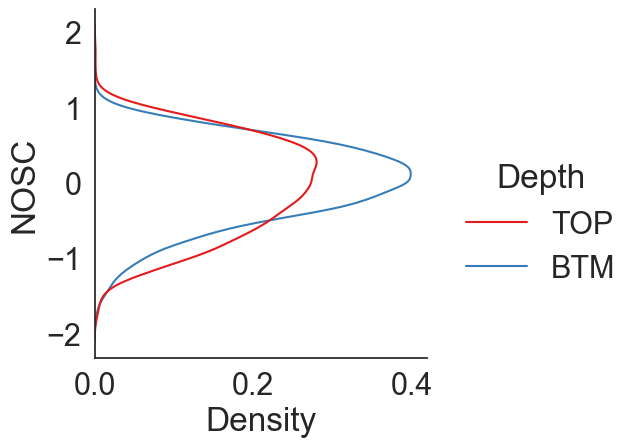

In [40]:
#individual sample: select prefered site from list

ax = sns.displot(df[df['Site'] == 'CFS1'], y = "NOSC", kind = "kde",
                 hue = 'Depth', hue_order = ['TOP','BTM'], 
                 palette = "Set1", fill = False)
# ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

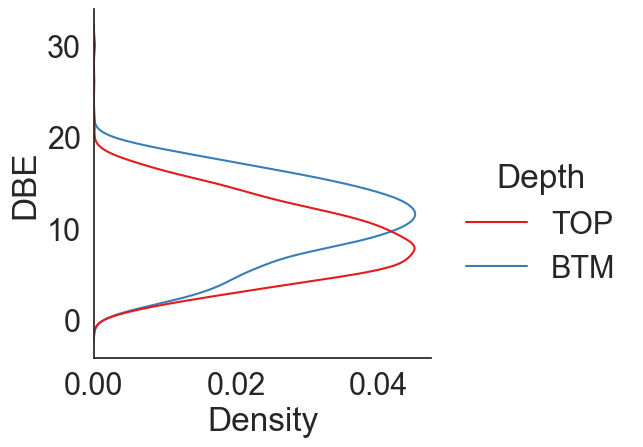

In [41]:
#DBE values for individual sample: select prefered site from list

ax = sns.displot(df[df['Site'] == 'CFS1'], y = "DBE", kind = "kde",
                 hue = 'Depth', hue_order = ['TOP','BTM'], 
                 palette = "Set1", fill = False)
# ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

(-0.5, 1.0)

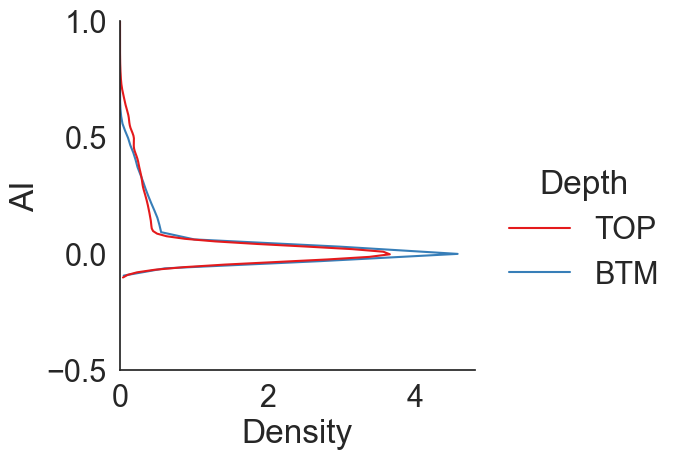

In [42]:
#Aromaticity values for individual sample: select prefered site from list

ax = sns.displot(df[df['Site'] == 'CFS1'], y = "AI", kind = "kde",
                 hue = 'Depth', hue_order = ['TOP','BTM'], 
                 palette = "Set1", fill = False)
# ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim(-0.5, 1)


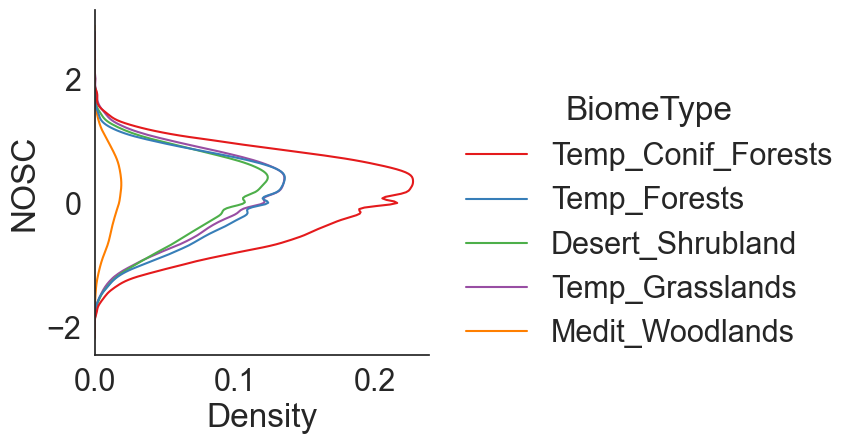

In [43]:
# NOSC values for all formulas by biome type

ax = sns.displot(df[(df['Depth'] == "TOP")], y = "NOSC", kind = "kde",
                 hue = 'BiomeType', 
                 palette = "Set1", fill = False)
# ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

(-3.0, 3.0)

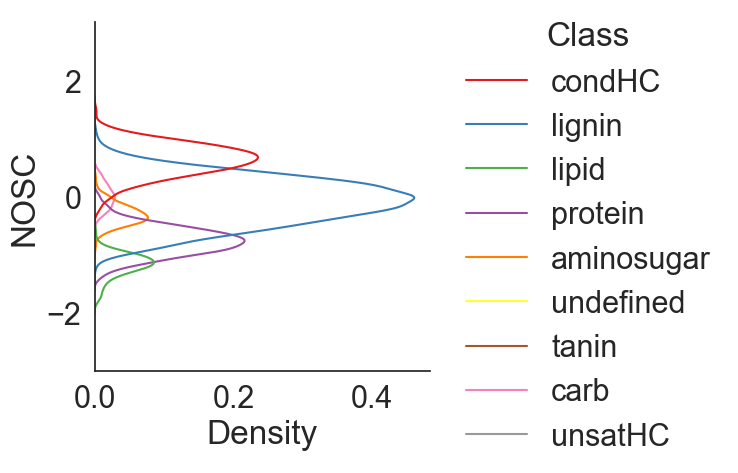

In [44]:
#NOSC values for an individual sample by compound class

class_order = ['condHC', 'lignin', 'lipid', 'protein', 'aminosugar', 'undefined',
       'tanin', 'carb', 'unsatHC']

ax = sns.displot(df[(df['Site'] == 'CFS1') & (df['Depth'] == 'TOP')], y = "NOSC", kind = "kde",
                 hue = 'Class', hue_order = class_order, 
                 palette = "Set1", fill = False)
# ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.ylim(-3, 3)
# plt.xlim(0,2)

[Text(0, 0, 'WLUP'),
 Text(1, 0, 'WLLO'),
 Text(2, 0, 'PPRH'),
 Text(3, 0, 'NWBC'),
 Text(4, 0, 'CFS2'),
 Text(5, 0, 'NWBB'),
 Text(6, 0, 'NWBA'),
 Text(7, 0, 'PRS1'),
 Text(8, 0, 'GRSM'),
 Text(9, 0, 'DELA'),
 Text(10, 0, 'LENO'),
 Text(11, 0, 'SCBI'),
 Text(12, 0, 'BLAN'),
 Text(13, 0, 'TALL'),
 Text(14, 0, 'MLBS'),
 Text(15, 0, 'ORNL'),
 Text(16, 0, 'SERC')]

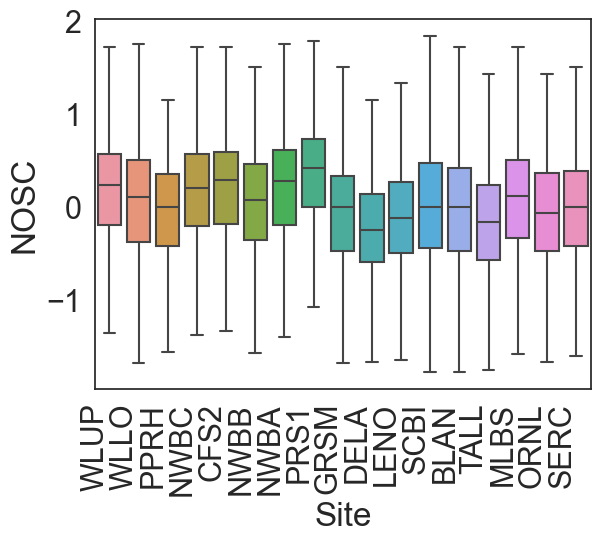

In [45]:
#NOSC values for all samples in select biome type as box plot 

ax = sns.boxplot(x="Site", y="NOSC", data=df[df["BiomeType"] == 'Temp_Forests'], showfliers=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
# plt.ylim(-5, 30)


[Text(0, 0, 'WLUP'),
 Text(1, 0, 'WLLO'),
 Text(2, 0, 'PPRH'),
 Text(3, 0, 'NWBC'),
 Text(4, 0, 'CFS2'),
 Text(5, 0, 'NWBB'),
 Text(6, 0, 'NWBA'),
 Text(7, 0, 'PRS1'),
 Text(8, 0, 'GRSM'),
 Text(9, 0, 'DELA'),
 Text(10, 0, 'LENO'),
 Text(11, 0, 'SCBI'),
 Text(12, 0, 'BLAN'),
 Text(13, 0, 'TALL'),
 Text(14, 0, 'MLBS'),
 Text(15, 0, 'ORNL'),
 Text(16, 0, 'SERC')]

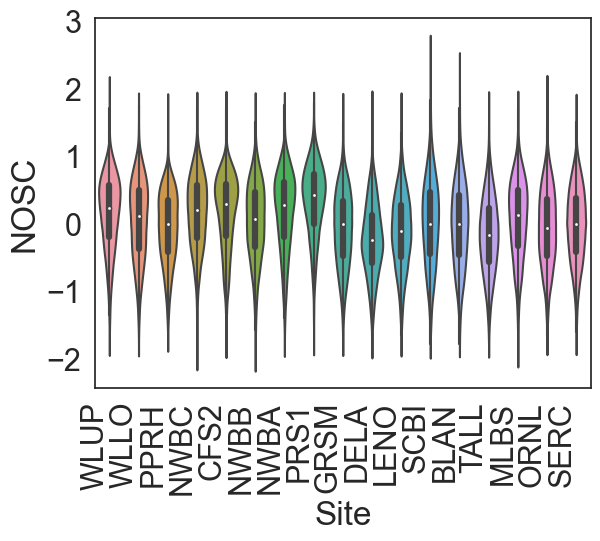

In [46]:
#NOSC values for all samples in select biome type as violin plot 

ax = sns.violinplot(x="Site", y="NOSC", data=df[df["BiomeType"] == 'Temp_Forests'], showfliers=False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')

[Text(0, 0, 'WLUP'),
 Text(1, 0, 'WLLO'),
 Text(2, 0, 'PPRH'),
 Text(3, 0, 'NWBC'),
 Text(4, 0, 'CFS2'),
 Text(5, 0, 'NWBB'),
 Text(6, 0, 'NWBA'),
 Text(7, 0, 'PRS1'),
 Text(8, 0, 'GRSM'),
 Text(9, 0, 'DELA'),
 Text(10, 0, 'LENO'),
 Text(11, 0, 'SCBI'),
 Text(12, 0, 'BLAN'),
 Text(13, 0, 'TALL'),
 Text(14, 0, 'MLBS'),
 Text(15, 0, 'ORNL'),
 Text(16, 0, 'SERC')]

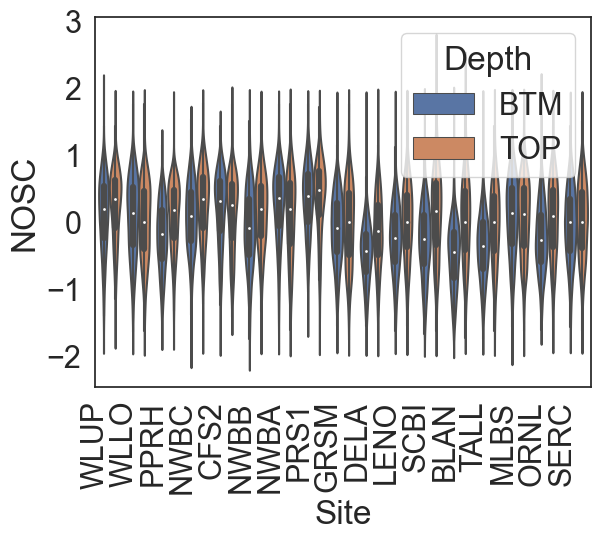

In [47]:
#NOSC values for all samples in select biome type by depth as violin plot 

ax = sns.violinplot(x="Site", y="NOSC", data=df[df["BiomeType"] == 'Temp_Forests'], showfliers=False, hue = "Depth")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right')

## Part 2: Data Exploration using Summed Formulas and Averaged Calculated Properties

For Part 2, we will use the "m" or "merged" dataframe containing averaged molecular properties calculated from molecular formulas, summed formulas, and soil measurements merged from the ShinyAp data.

In [48]:
#Inspect summary file containing averaged calculated properties, summed formulas and measured soil properties
#view summed and merged df "m"
m

Samples  Assignments  Mean_Error_PPM  StDev_Error_PPM  CHON_ct  CHO_ct  \
0    ANZA_BTM         3622        0.038922         0.033176     1505    2117   
1    ANZA_TOP         7211        0.051663         0.045260     3323    3888   
2    BLAN_BTM          812        0.033911         0.031231      176     636   
3    BLAN_TOP         8284        0.054404         0.046882     4043    4241   
4    CFS1_BTM         3878        0.049214         0.043303     1478    2400   
..        ...          ...             ...              ...      ...     ...   
123  WY09_TOP         9227        0.062013         0.054359     4306    4921   
124  WY10_BTM         3535        0.039591         0.032379     1179    2356   
125  WY10_TOP         8437        0.058286         0.051680     4100    4337   
126  WY15_BTM         3918        0.047433         0.042592     1111    2807   
127  WY15_TOP         6874        0.054640         0.048143     2441    4433   

      DBE_Mean   AI_Mean  AImod_Mean  NOSC_Mean  ...  pnm.abs.permeability_x  \
0     8.035340  0.115708    0.259335  -0.125443  ...                 6.61964   
1    10.210789  0.134320    0.296499  -0.039974  ...                21.10196   
2     5.395320  0.071502    0.177219  -0.499892  ...                23.52930   
3    10.807219  0.142744    0.308240   0.014033  ...               838.51390   
4    10.727953  0.074952    0.298662   0.003414  ...              1912.92000   
..         ...       ...         ...        ...  ...                     ...   
123  12.466999  0.164554    0.363001   0.168644  ...              1286.77300   
124   9.440453  0.122245    0.312855  -0.011484  ...                     NaN   
125  11.879934  0.163125    0.361053   0.140471  ...                     NaN   
126   9.408627  0.120340    0.272327  -0.099296  ...                 1.96500   
127  10.476287  0.124997    0.290052  -0.023868  ...              2422.92800   

     pnm.total.flow.rate_x  pnm.tortuosity_x  pnm.abs.permeability_y  \
0                 93.40387              1.84                 9.48881   
1                388.95730              1.81                12.26998   
2                339.61170              1.87                33.85940   
3              12085.59000              1.49               342.49170   
4              27617.81000              1.53              1874.20900   
..                     ...               ...                     ...   
123            18582.03000              1.69              1512.55900   
124                    NaN               NaN                     NaN   
125                    NaN               NaN                     NaN   
126               28.18030              1.92                58.12330   
127            34896.16000              1.61              3502.89400   

     pnm.total.flow.rate_y  pnm.tortuosity_y  pnm.abs.permeability_z  \
0                 146.1630              1.77                 6.10609   
1                 165.2507              1.69                 0.12125   
2                 592.1510              1.83                57.41300   
3                5981.5370              1.66               343.63990   
4               33279.5000              1.54                13.83900   
..                     ...               ...                     ...   
123             26429.7400              1.67               975.76070   
124                    NaN               NaN                     NaN   
125                    NaN               NaN                     NaN   
126              1020.2630              1.61               105.56620   
127             61255.4500              1.54               110.89960   

     pnm.total.flow.rate_z  pnm.tortuosity_z           BiomeType  
0                 33.65278              1.95    Desert_Shrubland  
1                  0.88000              2.24    Desert_Shrubland  
2                581.37600              1.70        Temp_Forests  
3               3478.10100              1.84        Temp_Forests  
4                13

In [49]:
# make a list of all columns to refer back to

col = m.columns.tolist()
col


['Samples',
 'Assignments',
 'Mean_Error_PPM',
 'StDev_Error_PPM',
 'CHON_ct',
 'CHO_ct',
 'DBE_Mean',
 'AI_Mean',
 'AImod_Mean',
 'NOSC_Mean',
 'NOSC_StDev',
 'NOSC_median',
 'OC_Mean',
 'OC_StDev',
 'OC_median',
 'HC_Mean',
 'HC_StDev',
 'HC_median',
 'C_mean',
 'GFE_Mean',
 'Lignin_ct',
 'ConHC_ct',
 'Lipid_ct',
 'UnsatHC_ct',
 'Protein_ct',
 'AminoSugar_ct',
 'Carb_ct',
 'Tannin_ct',
 'Other_ct',
 'Lignin',
 'ConHC',
 'Lipid',
 'UnsatHC',
 'Protein',
 'AminoSugar',
 'Carb',
 'Tannin',
 'Other',
 'CHO',
 'CHON',
 'Site',
 'Depth',
 'Sample_ID',
 'biome_name',
 'latitude',
 'longitude',
 'mean_GWC',
 'K_mg_per_kg',
 'SO4.S_mg_per_kg',
 'B_mg_per_kg',
 'Zn_mg_per_kg',
 'Mn_mg_per_kg',
 'Cu_mg_per_kg',
 'Fe_mg_per_kg',
 'Ca_Meq_per_100_g',
 'Mg_Meq_per_100_g',
 'Na_Meq_per_100_g',
 'Total_Bases_Meq_per_100_g',
 'CEC_Meq_per_100_g',
 'TKN_pct',
 'Total_Sulfur_pct',
 'Total_Nitrogen_pct',
 'Total_Carbon_pct',
 'C_to_N_ratio',
 'NO3.N_mg_per_g_of_soil_mean',
 'NH4.N_mg_per_g_of_soil_mean'

### 1.  Plot the number of molecular formulas assigned 

#### Assignments by depth for an individual site

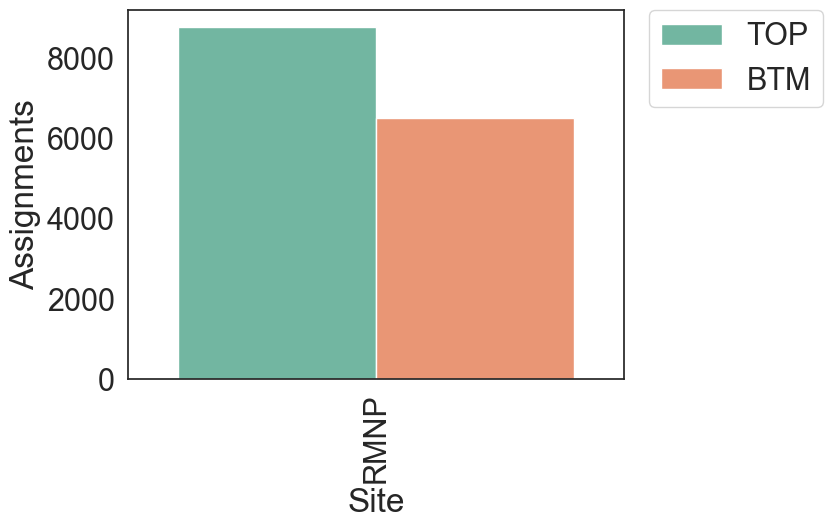

In [50]:
ax = sns.barplot(x='Site', y="Assignments", hue="Depth",                 
                 palette="Set2", hue_order = ['TOP','BTM'],
                 data=m[m['Site'] == 'RMNP']
                    )
ax.tick_params(axis='x', rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

#### Assignments for each BiomeType

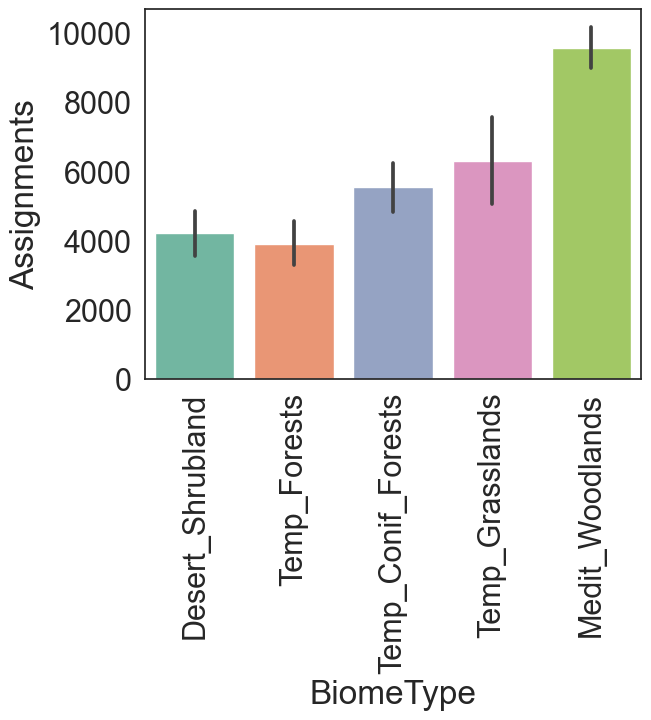

In [51]:
ax = sns.barplot(x='BiomeType', y="Assignments", #hue="BiomeType",                  
                 palette="Set2", 
                 data=m )
ax.tick_params(axis='x', rotation=90)

#### Assignments by depth for each BiomeType

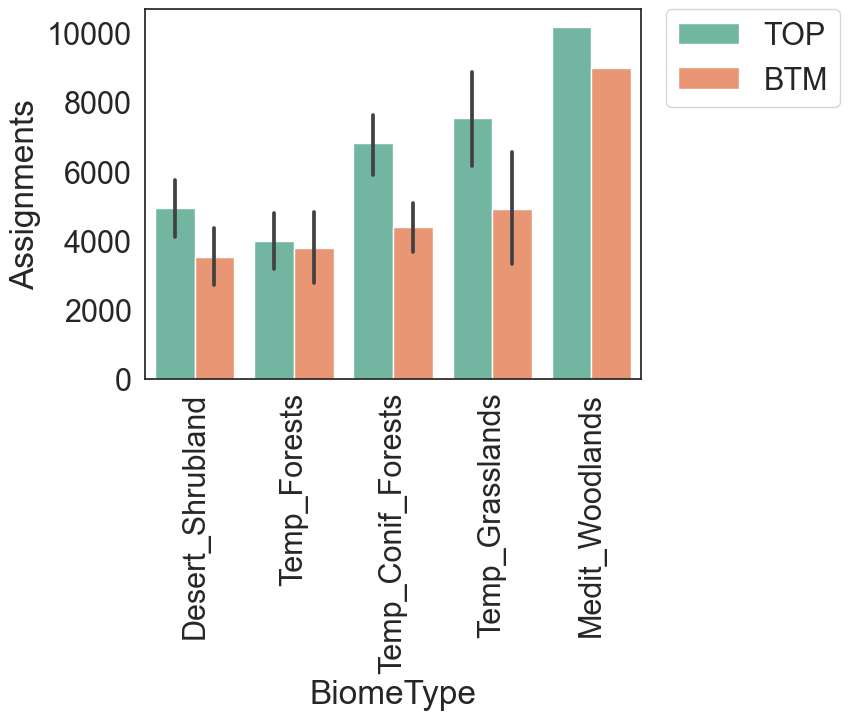

In [52]:
ax = sns.barplot(x='BiomeType', y="Assignments", hue="Depth", 
                 palette="Set2", hue_order = ("TOP","BTM"),
                 data=m
                )
ax.tick_params(axis='x', rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

#### Assignments by site and depth for each BiomeType

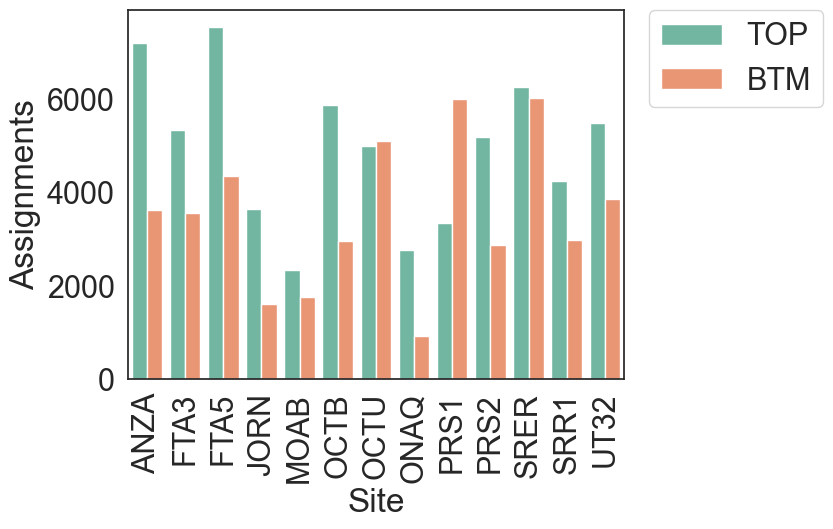

In [53]:
ax = sns.barplot(x='Site', y="Assignments", hue="Depth", 
                 palette="Set2", 
                 hue_order = ['TOP','BTM'],
#                  dodge = False,
                 data=m[(m['BiomeType'] == 'Desert_Shrubland')]
                )
ax.tick_params(axis='x', rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

### 2. Plot Elemental Compostion

#### Change to longform data using elemental formula types to plot elemental composition

In [54]:
columns = ['Site','BiomeType', 'Depth']
id_vars = columns
value_vars = ['CHO','CHON'] 
dfec = pd.melt(m,id_vars = id_vars,
                       value_vars = value_vars,
                       var_name='El_comp',
                       value_name = 'Mean_Fraction')

In [55]:
#display new df
dfec

Site           BiomeType Depth El_comp  Mean_Fraction
0    ANZA    Desert_Shrubland   BTM     CHO       0.584484
1    ANZA    Desert_Shrubland   TOP     CHO       0.539176
2    BLAN        Temp_Forests   BTM     CHO       0.783251
3    BLAN        Temp_Forests   TOP     CHO       0.511951
4    CFS1  Temp_Conif_Forests   BTM     CHO       0.618876
..    ...                 ...   ...     ...            ...
251  WY09  Temp_Conif_Forests   TOP    CHON       0.466674
252  WY10  Temp_Conif_Forests   BTM    CHON       0.333522
253  WY10  Temp_Conif_Forests   TOP    CHON       0.485955
254  WY15  Temp_Conif_Forests   BTM    CHON       0.283563
255  WY15  Temp_Conif_Forests   TOP    CHON       0.355106

[256 rows x 5 columns]

#### Plot bar graphs of elemental composition for an individual sample

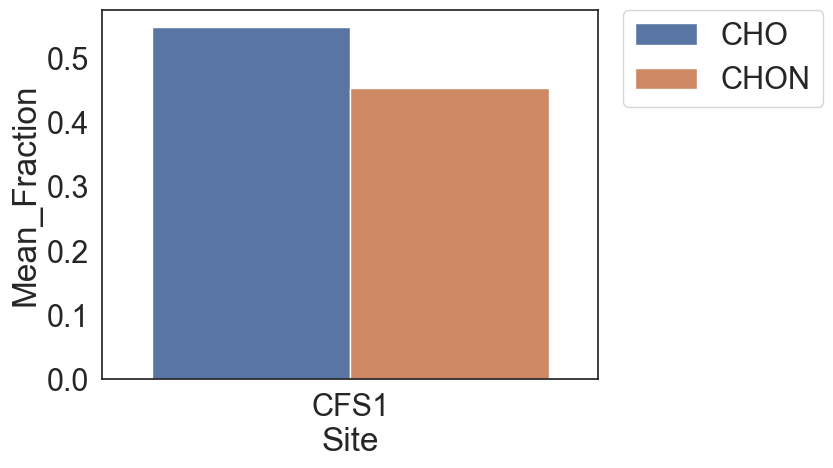

In [56]:
ax = sns.barplot(x="Site", y="Mean_Fraction", hue="El_comp",
                 data=dfec[(dfec['Site']== 'CFS1') & (dfec['Depth']== 'TOP')]
                )

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#### Plot bar graphs of elemental composition by site

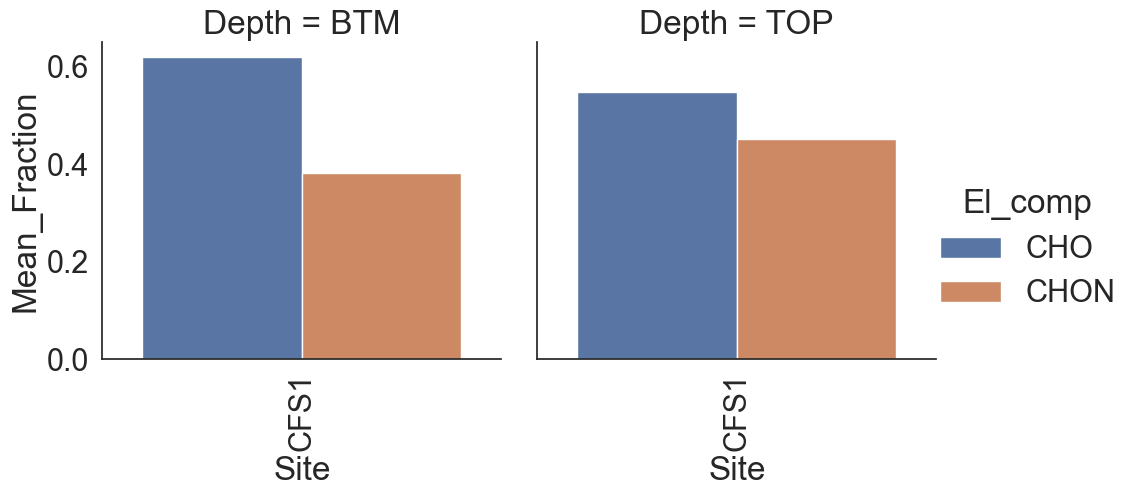

In [57]:
ax = sns.catplot(data=dfec[dfec['Site']== 'CFS1'], x='Site', y='Mean_Fraction', hue = 'El_comp', 
    col='Depth', kind='bar', dodge = True ) 

ax.tick_params(axis='x', rotation=90)

#### Plot bar graphs of elemental composition according to BiomeType

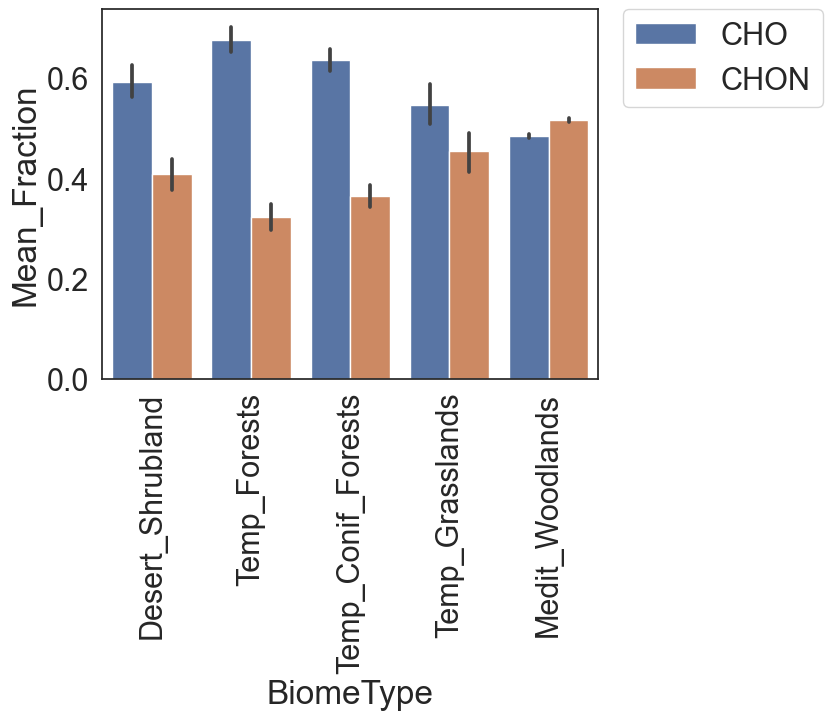

In [58]:

ax = sns.barplot(x="BiomeType", y="Mean_Fraction", hue="El_comp",
                 data=dfec )

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.tick_params(axis='x', rotation=90)

#### Plot bar graphs of elemental composition for all sites in a selected BiomeType

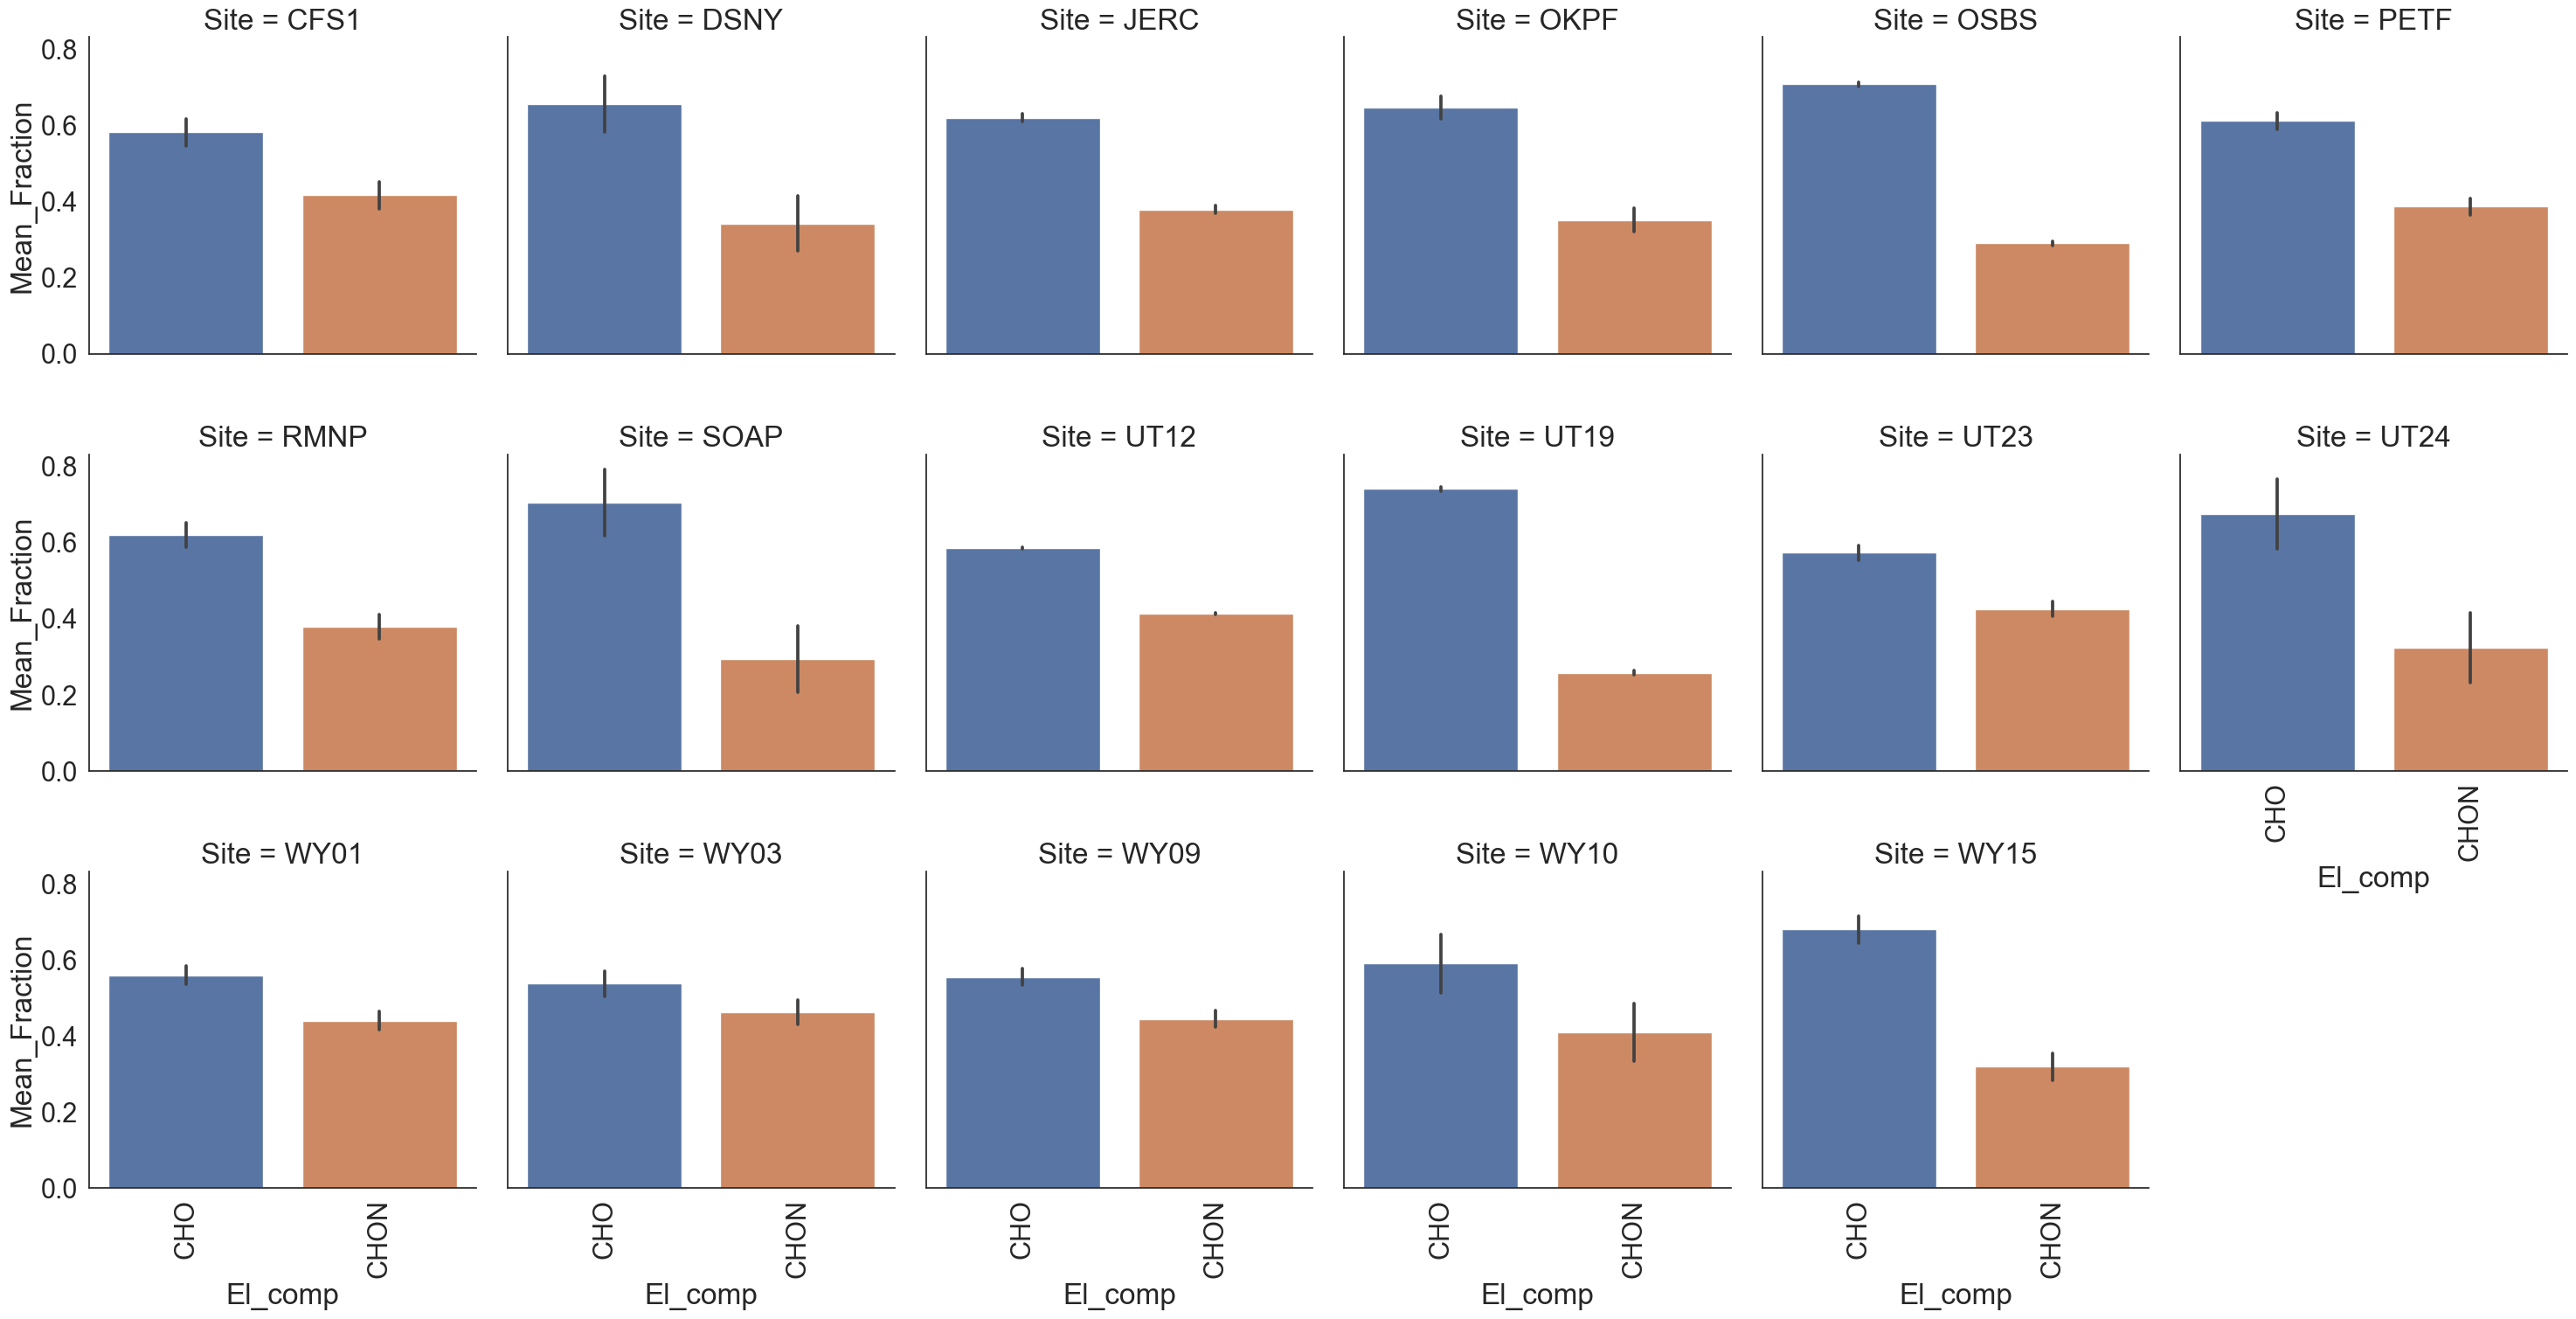

In [59]:
ax = sns.catplot(data=dfec[(dfec['BiomeType'] == 'Temp_Conif_Forests')], x='El_comp', y='Mean_Fraction', 
                 hue = 'El_comp', col='Site', kind='bar', col_wrap=6, 
                 dodge = False)

ax.tick_params(axis='x', rotation=90)

#### Plot bar graphs of elemental composition for all samples (top/bottom) in a BiomeType 

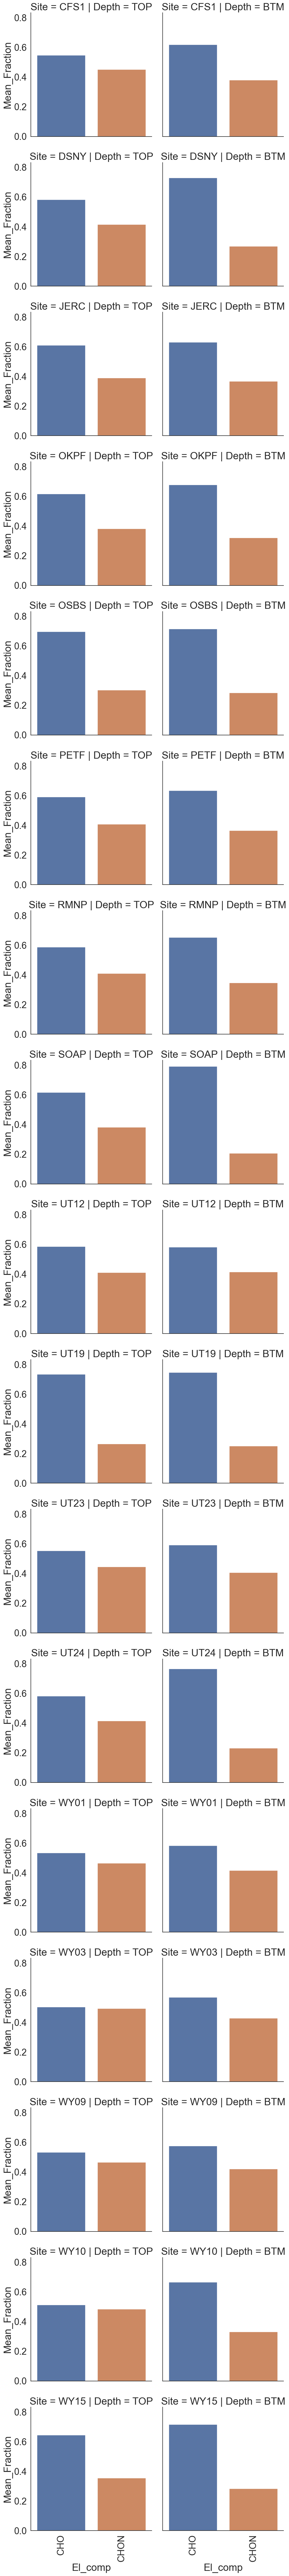

In [60]:
ax = sns.catplot(data=dfec[(dfec['BiomeType'] == 'Temp_Conif_Forests')], x='El_comp', y='Mean_Fraction', 
                 hue = 'El_comp', col='Depth', row = 'Site', kind='bar',  col_order = ("TOP","BTM"),
                 dodge = False)

ax.tick_params(axis='x', rotation=90)

### 3. Plot Compound Class Compostion

#### Change to longform data using compound class formula types to plot class composition

In [61]:
#select compound classes and change to long form data to plot composition

columns_c = ['Site', 'BiomeType','Depth']
id_vars_c = columns_c
value_vars_c = ['Lignin', 'Lipid', 'ConHC', 'Carb', 'AminoSugar','Tannin', 'Protein','UnsatHC', 'Other'] 
dfc = pd.melt(m,id_vars = id_vars_c,
                       value_vars = value_vars_c,
                       var_name='Class',
                       value_name = 'Mean_Fraction')

#### Plot bar graphs of elemental composition for an individual sample

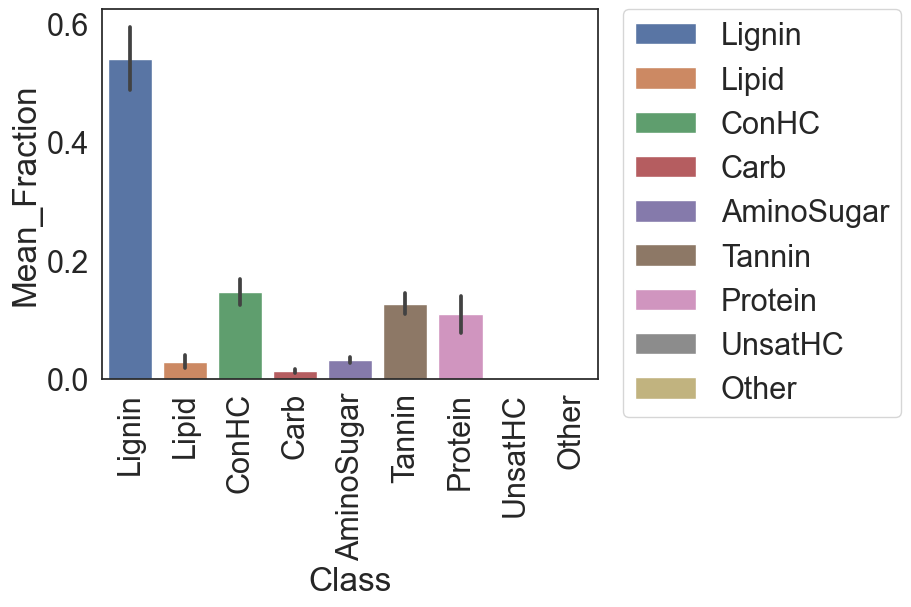

In [62]:
ax = sns.barplot(data=dfc[(dfc['Site'] == 'CFS1')], x='Class', y='Mean_Fraction', hue = 'Class',
                 dodge = False) 

ax.tick_params(axis='x', rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

#### Plot bar graphs of elemental composition by site

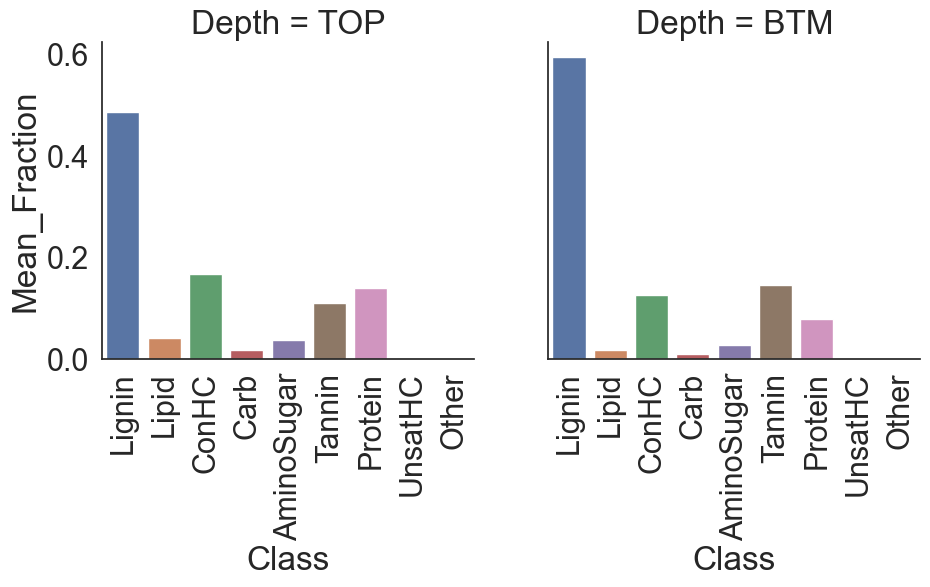

In [63]:
ax = sns.catplot(data=dfc[(dfc['Site'] == 'CFS1')], x='Class', y='Mean_Fraction', hue = 'Class', #palette="Set1",
    col='Depth', kind='bar', col_wrap=2, col_order=['TOP','BTM'], dodge = False) 

ax.tick_params(axis='x', rotation=90)

#### Plot bar graphs of elemental composition by BiomeType

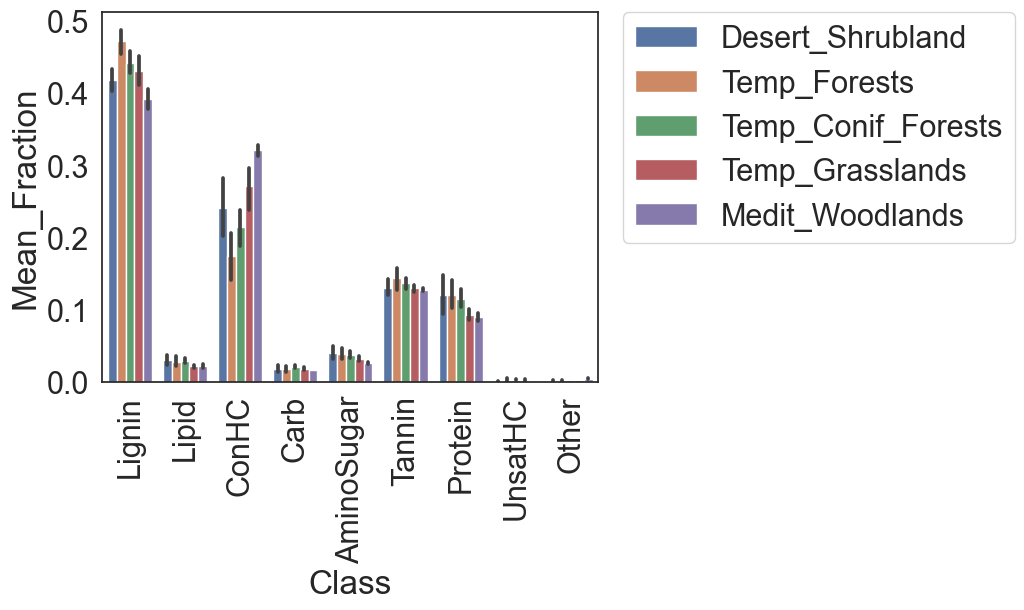

In [64]:
ax = sns.barplot(x="Class", y="Mean_Fraction", hue="BiomeType", #palette="Set1", 
                 data=dfc)
ax.tick_params(axis='x', rotation=90)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#### Plot bar graphs of elemental composition for all sites in a BiomeType

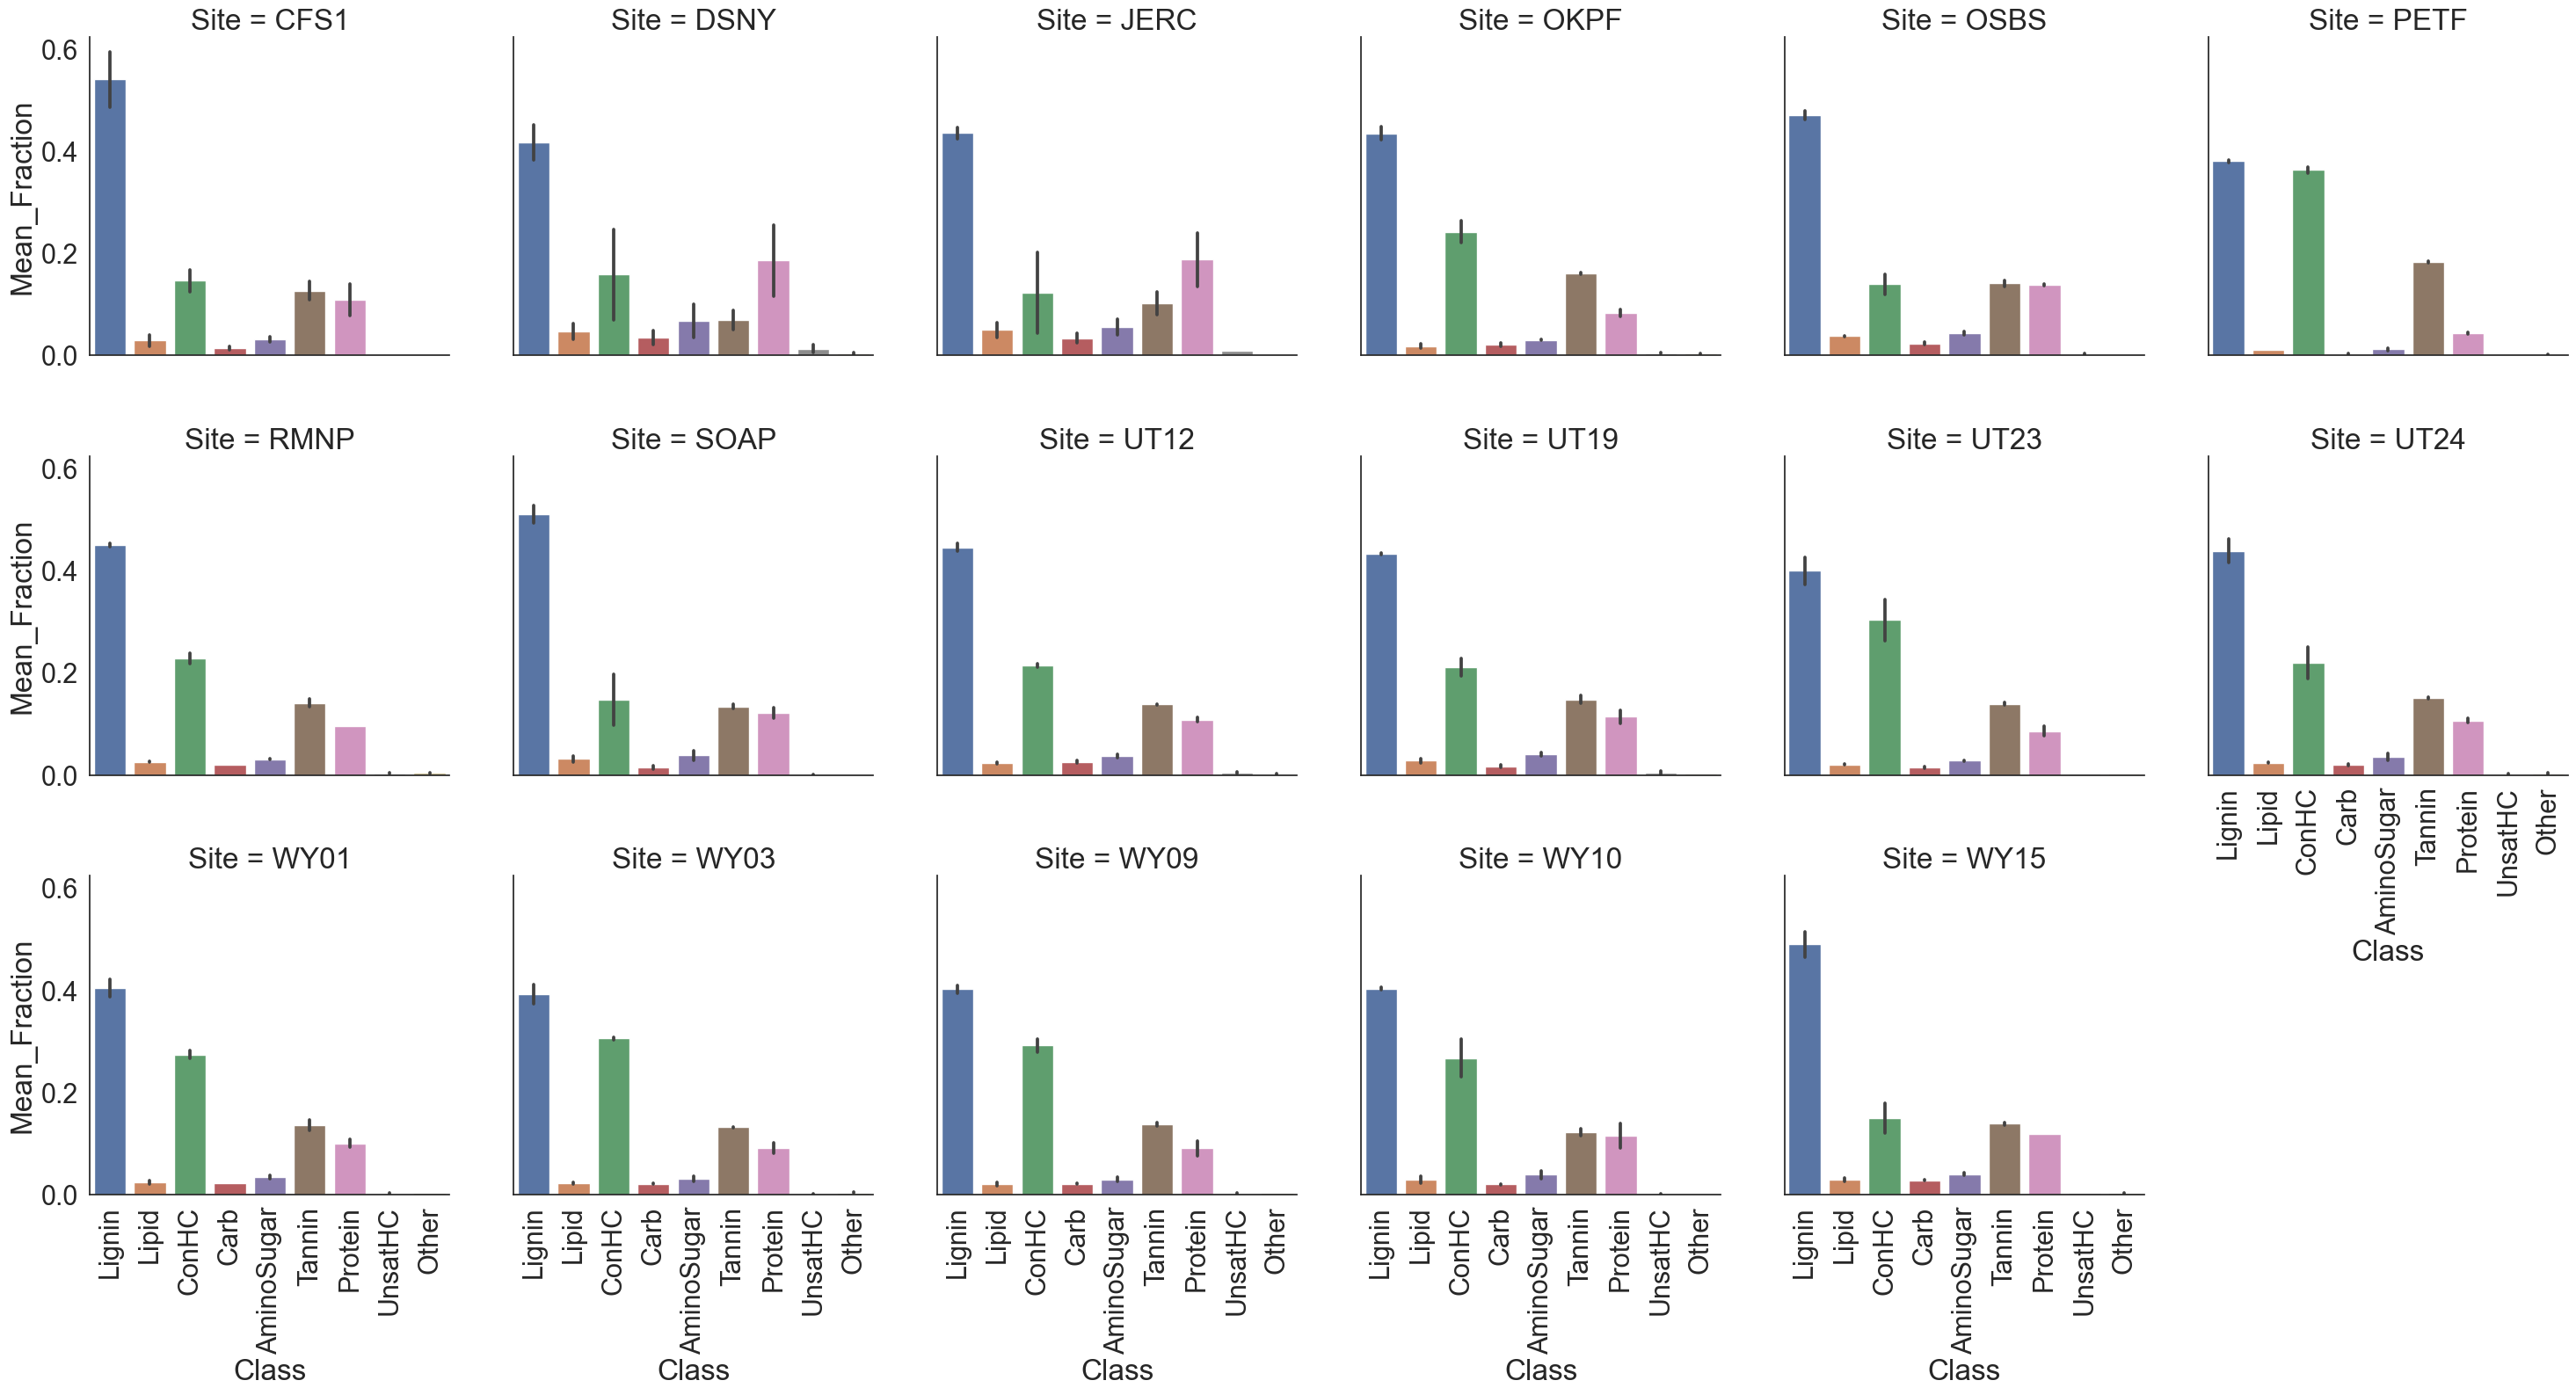

In [65]:
sns.set(font_scale=2)
sns.set_style("white")

ax = sns.catplot(data=dfc[(dfc['BiomeType'] == 'Temp_Conif_Forests')], x='Class', y='Mean_Fraction', hue = 'Class', #palette="Set1",
    col='Site', kind='bar', col_wrap=6, 
                 dodge = False)

ax.tick_params(axis='x', rotation=90)

#### Plot bar graphs of elemental composition for all samples (top/bottom) in a BiomeType 

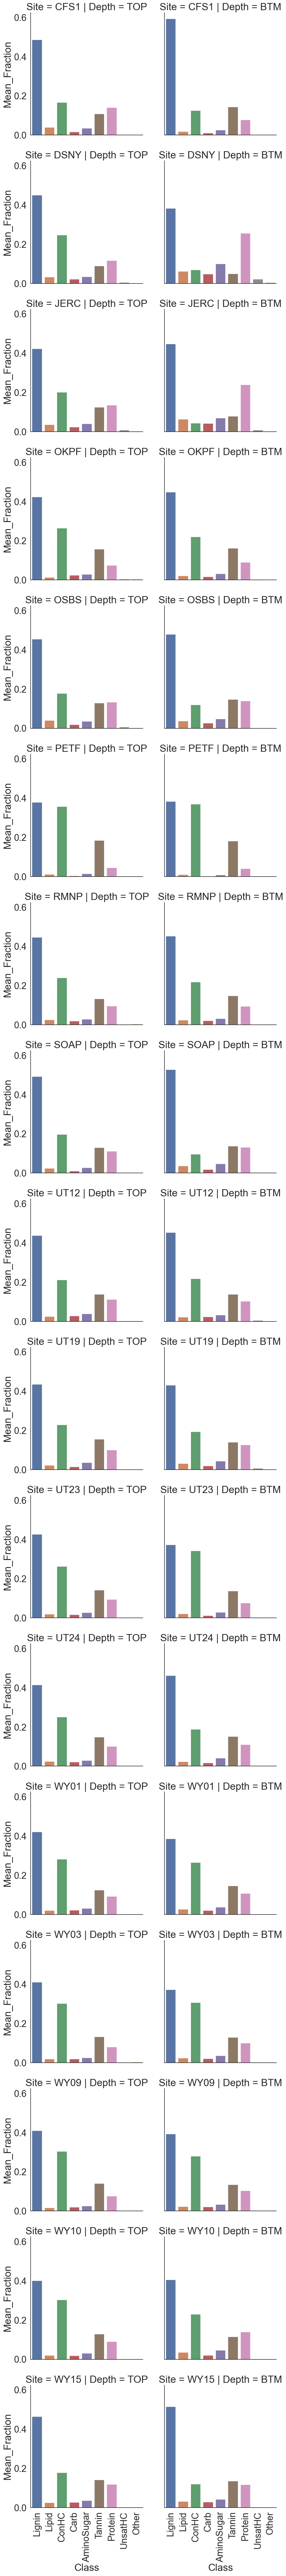

In [66]:
ax = sns.catplot(data=dfc[(dfc['BiomeType'] == 'Temp_Conif_Forests')], x='Class', y='Mean_Fraction', hue = 'Class', 
                 #palette="Set1",
    col='Depth', row = 'Site', kind='bar', col_order = ("TOP", "BTM"), 
                 dodge = False)

ax.tick_params(axis='x', rotation=90)

### 4.  Plot average calculated properties 

#### Plot Average O/C vs H/C (Average van Krevelen)

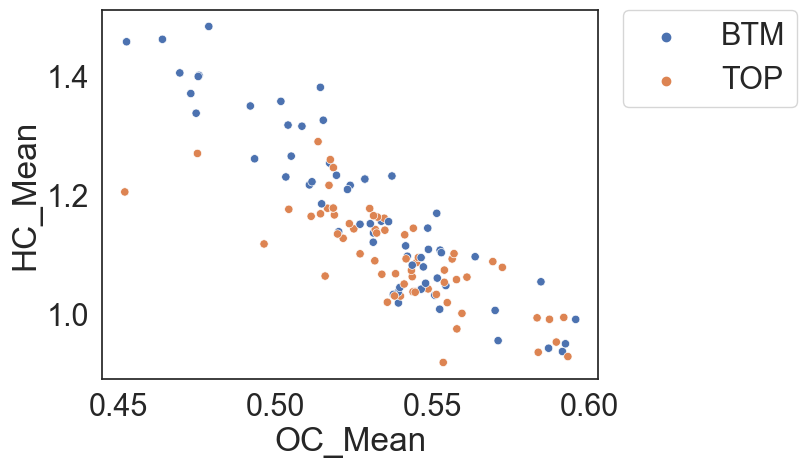

In [67]:
# by depth
ax = sns.scatterplot(x="OC_Mean", y="HC_Mean", hue="Depth", 
                 data=m)                    

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

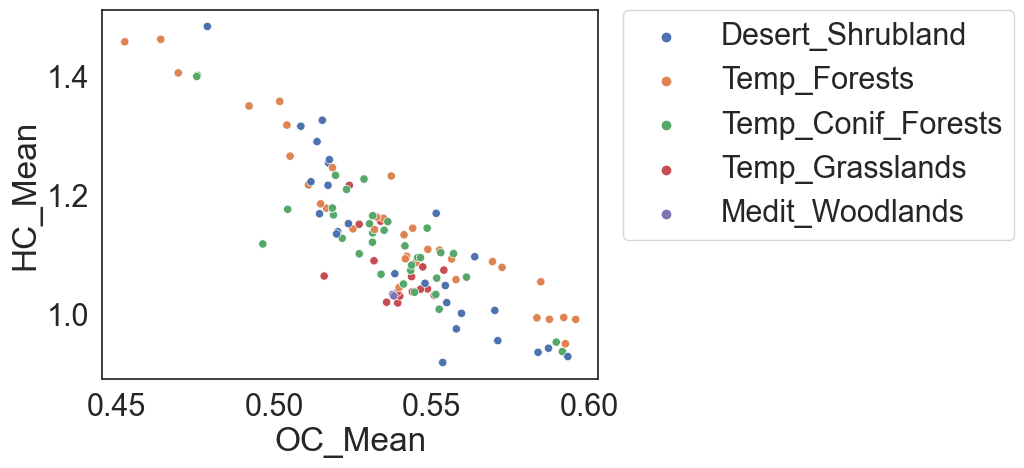

In [68]:
#by BiomeType

ax = sns.scatterplot(x="OC_Mean", y="HC_Mean", hue="BiomeType", 
                 data=m )
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

#### Plot Average NOSC, AI, AImod, DBE

##### All samples in a given BiomeType

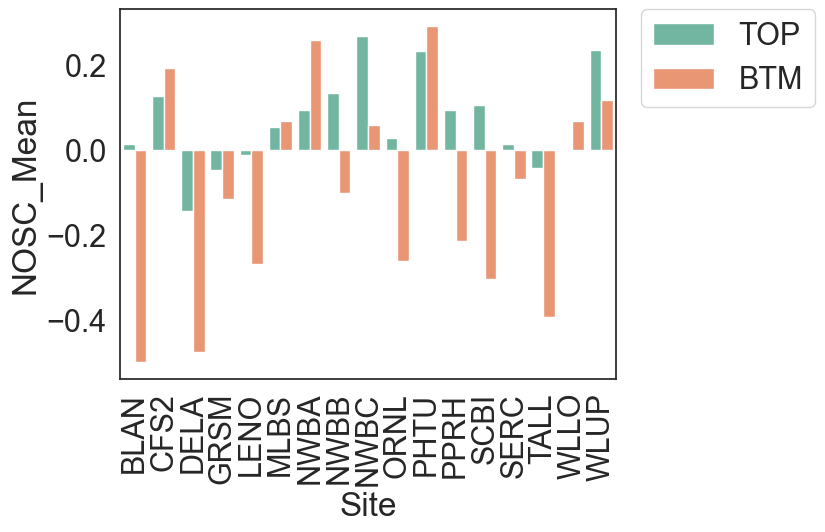

In [69]:
#all samples in a given BiomeType

ax = sns.barplot(x='Site', y="NOSC_Mean", hue="Depth", palette="Set2", hue_order = ['TOP','BTM'], 
                 data=m[m['BiomeType'] == "Temp_Forests"],
                )
ax.tick_params(axis='x', rotation=90)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

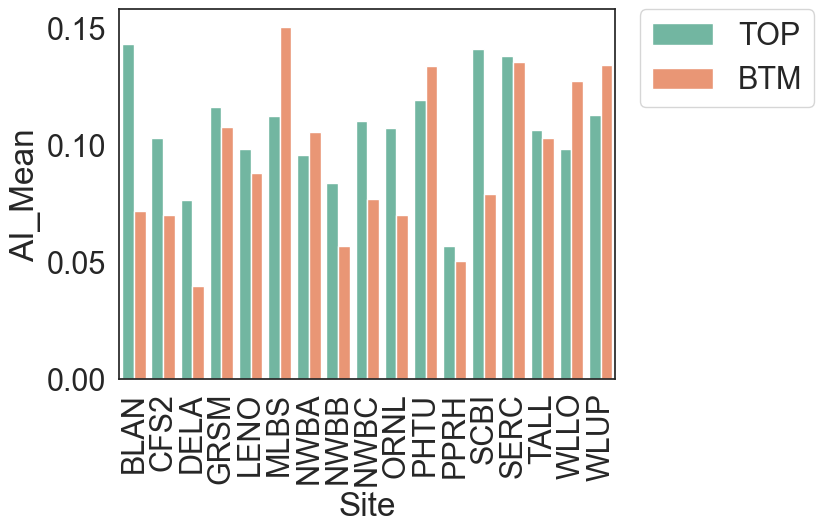

In [70]:
ax = sns.barplot(x='Site', y="AI_Mean", 
                 data=m[m['BiomeType'] == 'Temp_Forests'], palette="Set2",hue = "Depth", hue_order = ("TOP","BTM"))
ax.tick_params(axis='x', rotation=90)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

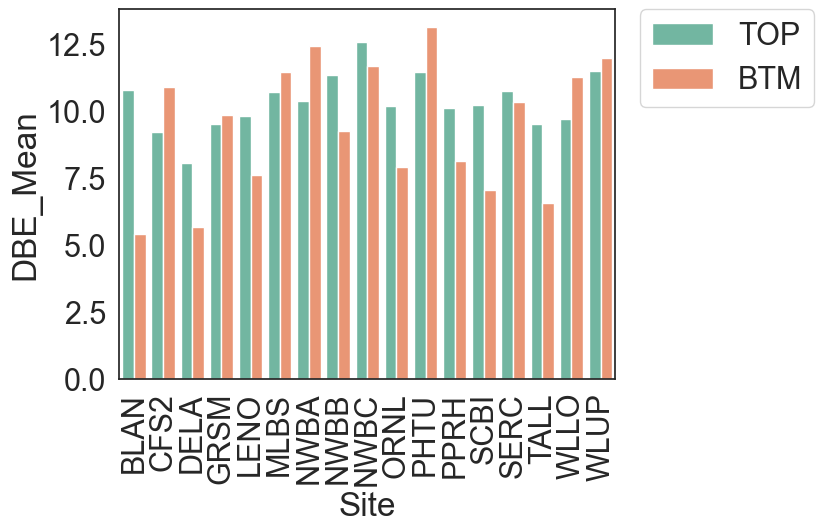

In [71]:
ax = sns.barplot(x='Site', y="DBE_Mean", 
                 data=m[m['BiomeType'] == 'Temp_Forests'],palette="Set2", hue = "Depth", hue_order = ("TOP","BTM"))
ax.tick_params(axis='x', rotation=90)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

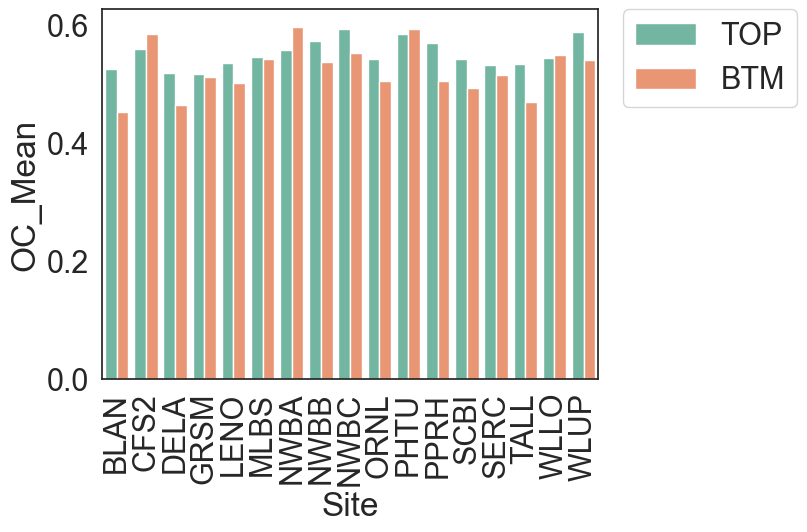

In [72]:
ax = sns.barplot(x='Site', y="OC_Mean", 
                 data=m[m['BiomeType'] == 'Temp_Forests'],palette="Set2", hue = "Depth", hue_order = ("TOP","BTM"))
ax.tick_params(axis='x', rotation=90)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

##### All samples across BiomeTypes

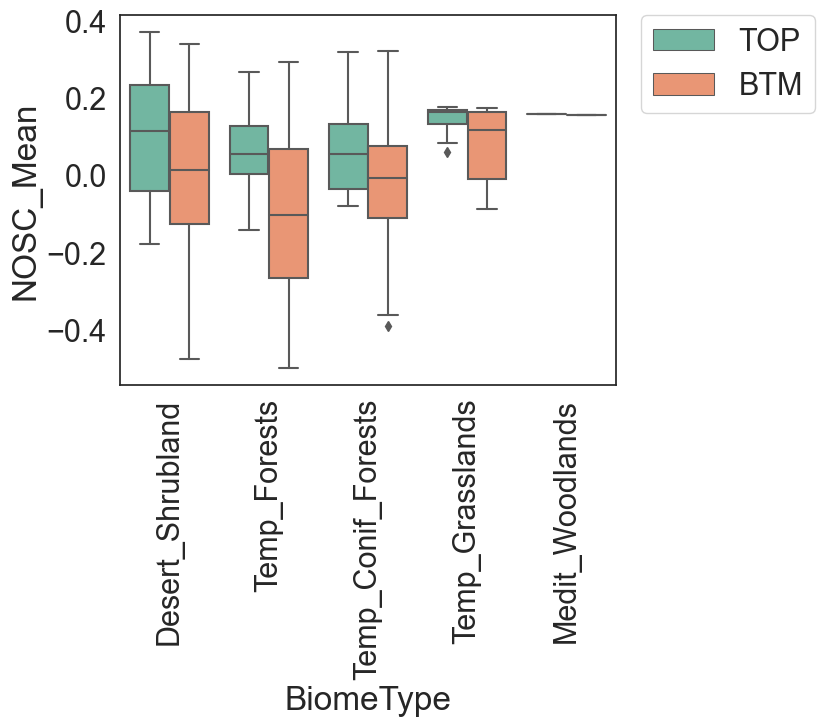

In [73]:
#all samples across biome types

ax = sns.boxplot(x='BiomeType', y="NOSC_Mean", hue="Depth", palette="Set2",hue_order = ['TOP','BTM'], 
                 data=m)
ax.tick_params(axis='x', rotation=90)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

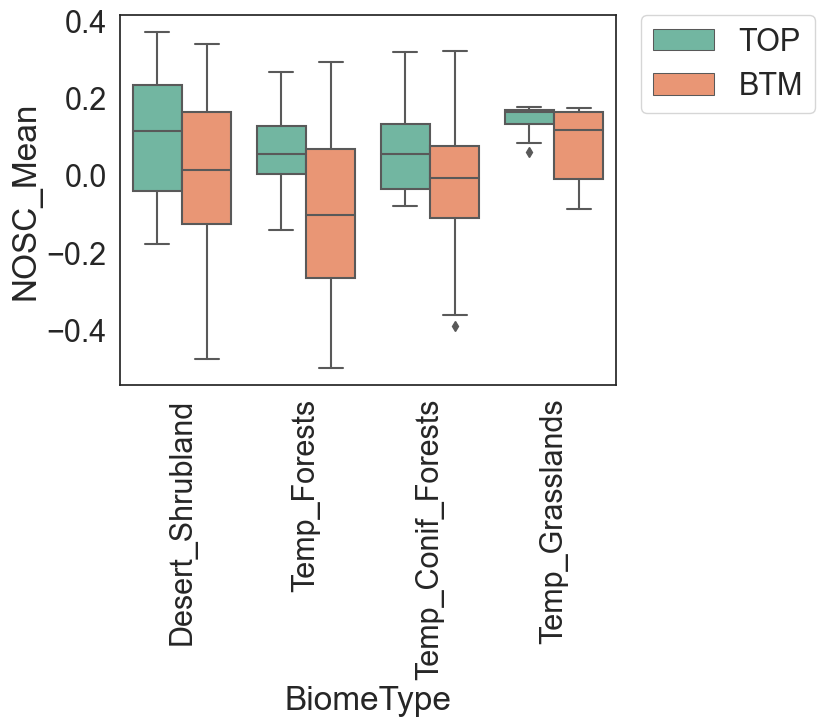

In [74]:
#remove BiomeType with only 1 site

ax = sns.boxplot(x='BiomeType', y="NOSC_Mean", hue="Depth", palette="Set2", hue_order = ['TOP','BTM'], 
                 data=m[(m['BiomeType'] != 'Medit_Woodlands')]
                )
ax.tick_params(axis='x', rotation=90)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

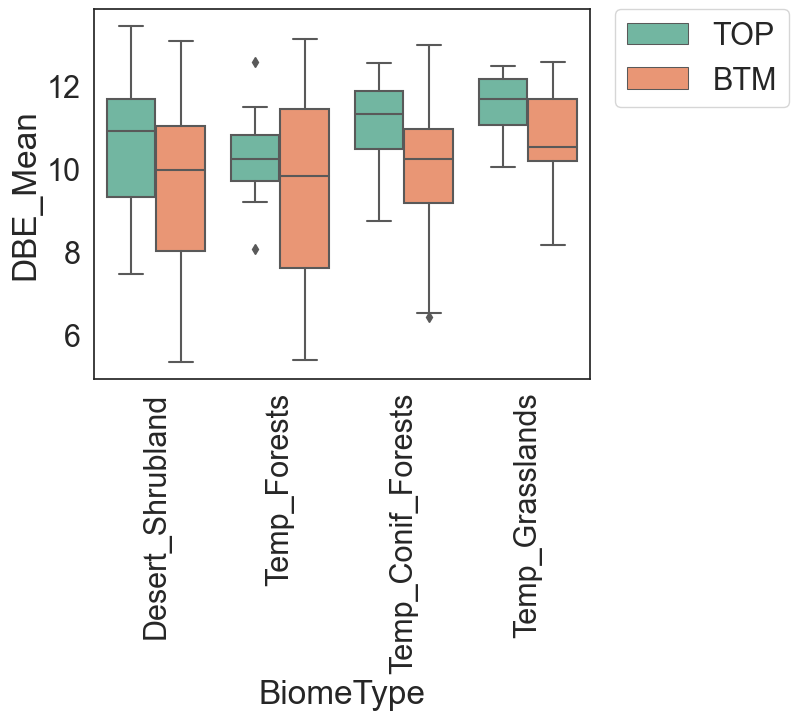

In [75]:
#remove BiomeType with only 1 site

ax = sns.boxplot(x='BiomeType', y="DBE_Mean", hue="Depth", palette="Set2", hue_order = ['TOP','BTM'], 
                 data=m[(m['BiomeType'] != 'Medit_Woodlands')]
                )
ax.tick_params(axis='x', rotation=90)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

### 5. Plot Trends: Correlate FT-ICR-MS Calculated Properties with Measured Soil Properties

In [76]:
col = m.columns.tolist()
col

['Samples',
 'Assignments',
 'Mean_Error_PPM',
 'StDev_Error_PPM',
 'CHON_ct',
 'CHO_ct',
 'DBE_Mean',
 'AI_Mean',
 'AImod_Mean',
 'NOSC_Mean',
 'NOSC_StDev',
 'NOSC_median',
 'OC_Mean',
 'OC_StDev',
 'OC_median',
 'HC_Mean',
 'HC_StDev',
 'HC_median',
 'C_mean',
 'GFE_Mean',
 'Lignin_ct',
 'ConHC_ct',
 'Lipid_ct',
 'UnsatHC_ct',
 'Protein_ct',
 'AminoSugar_ct',
 'Carb_ct',
 'Tannin_ct',
 'Other_ct',
 'Lignin',
 'ConHC',
 'Lipid',
 'UnsatHC',
 'Protein',
 'AminoSugar',
 'Carb',
 'Tannin',
 'Other',
 'CHO',
 'CHON',
 'Site',
 'Depth',
 'Sample_ID',
 'biome_name',
 'latitude',
 'longitude',
 'mean_GWC',
 'K_mg_per_kg',
 'SO4.S_mg_per_kg',
 'B_mg_per_kg',
 'Zn_mg_per_kg',
 'Mn_mg_per_kg',
 'Cu_mg_per_kg',
 'Fe_mg_per_kg',
 'Ca_Meq_per_100_g',
 'Mg_Meq_per_100_g',
 'Na_Meq_per_100_g',
 'Total_Bases_Meq_per_100_g',
 'CEC_Meq_per_100_g',
 'TKN_pct',
 'Total_Sulfur_pct',
 'Total_Nitrogen_pct',
 'Total_Carbon_pct',
 'C_to_N_ratio',
 'NO3.N_mg_per_g_of_soil_mean',
 'NH4.N_mg_per_g_of_soil_mean'

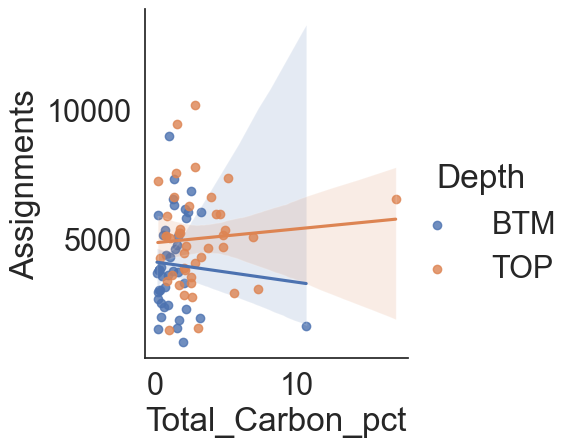

In [77]:
ax = sns.lmplot(x='Total_Carbon_pct', y="Assignments", hue="Depth",                  
                 #"#palette="Set1", 
                 data=m
                )
# ax.tick_params(axis='x', rotation=90)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

In [85]:
#Convert measured soil properties to float for correlation plots
#select only numeric columns, not columns with character data
char_cols = {'Samples','Site', 'Depth', 'Sample_ID', 'biome_name', 'BiomeType'}
num_cols = [item for item in col if item not in char_cols ]
ncols = m.columns.drop(char_cols)
m[ncols] = m[ncols].astype(float)

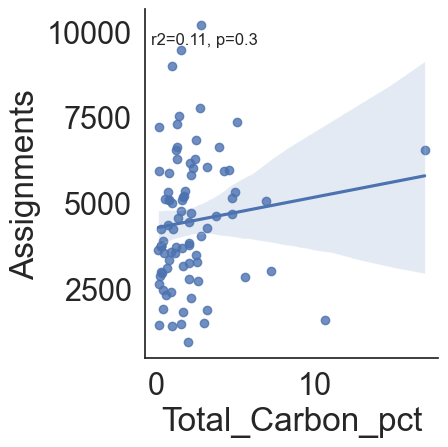

In [86]:
#need to remove nan values to calculate r2 regression 
rmvnan = m[m['Total_Carbon_pct'].notna()]

g = sns.lmplot(x='Total_Carbon_pct', y='Assignments', data=rmvnan, #hue = 'Depth'
#                height=5, aspect=1
         )

def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['Total_Carbon_pct'], data['Assignments'])
    ax = plt.gca()
    ax.text(.02, .9, 'r2={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes, fontsize=12)
    
g.map_dataframe(annotate)
plt.show()

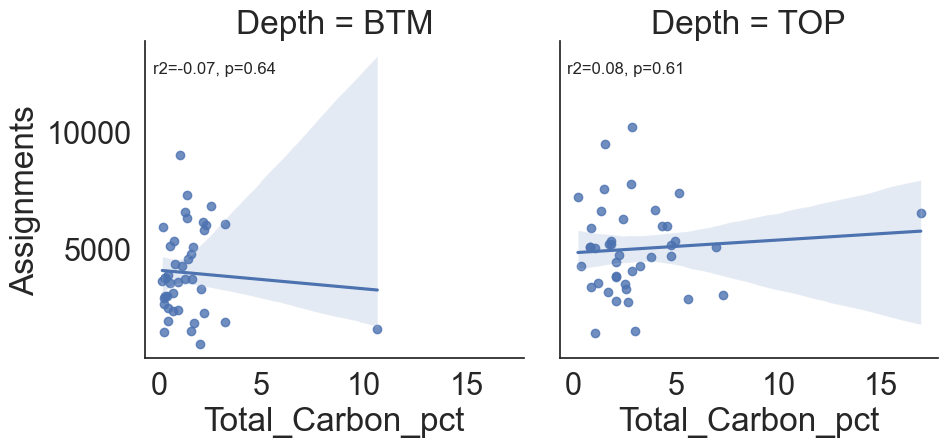

In [87]:
g = sns.lmplot(x='Total_Carbon_pct', y='Assignments', data=rmvnan, col = 'Depth'
#                height=5, aspect=1
              )

def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['Total_Carbon_pct'], data['Assignments'])
    ax = plt.gca()
    ax.text(.02, .9, 'r2={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes, fontsize=12)
    
g.map_dataframe(annotate)
plt.show()

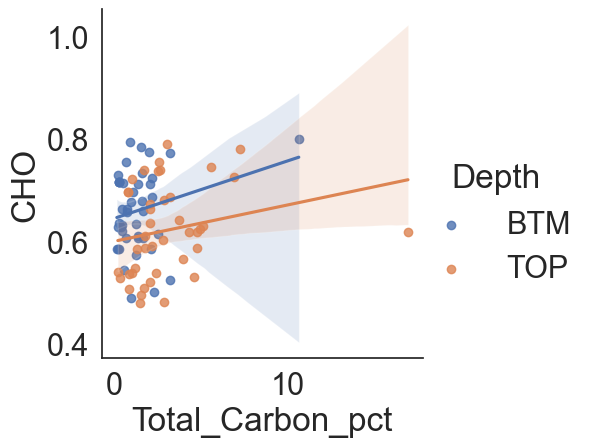

In [88]:
ax = sns.lmplot(x='Total_Carbon_pct', y="CHO", hue="Depth",                  
                 #"#palette="Set1", 
#                  dodge = False,
                 data=m
                )
# ax.tick_params(axis='x', rotation=90)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

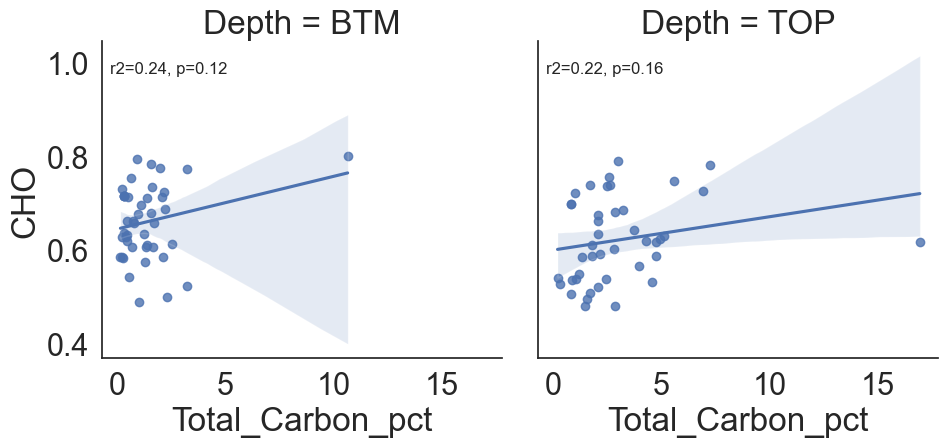

In [89]:
#need to remove nan values to calculate r2 regression 
rmvnan = m[m['Total_Carbon_pct'].notna()]
g = sns.lmplot(x='Total_Carbon_pct', y='CHO', data=rmvnan, col = 'Depth'
#                height=5, aspect=1
              )

def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['Total_Carbon_pct'], data['CHO'])
    ax = plt.gca()
    ax.text(.02, .9, 'r2={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes, fontsize=12)
    
g.map_dataframe(annotate)
plt.show()

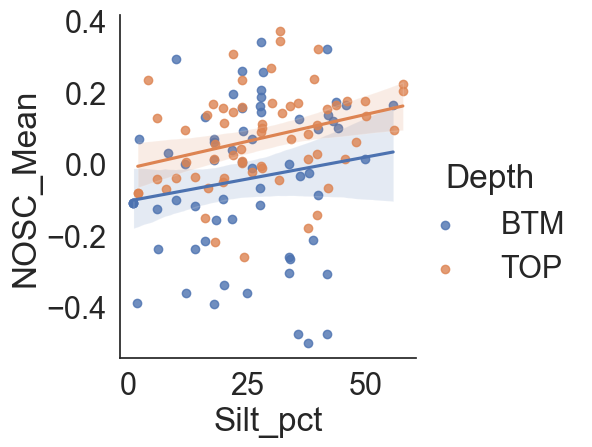

In [90]:
ax = sns.lmplot(x='Silt_pct', y="NOSC_Mean", hue="Depth",                  
                 #"#palette="Set1", 
#                  dodge = False,
                 data=m
                )
# ax.tick_params(axis='x', rotation=90)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

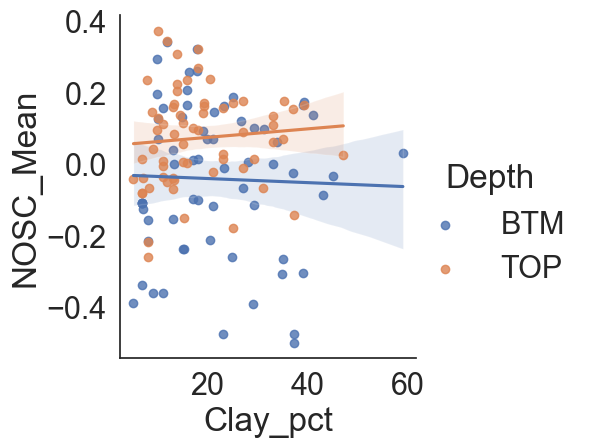

In [91]:
ax = sns.lmplot(x='Clay_pct', y="NOSC_Mean", hue="Depth",                  
                 #"#palette="Set1", 
#                  dodge = False,
                 data=m
                )
# ax.tick_params(axis='x', rotation=90)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

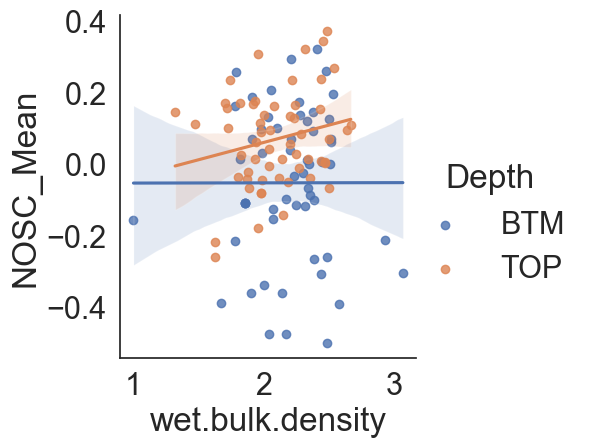

In [92]:
ax = sns.lmplot(x='wet.bulk.density', y="NOSC_Mean", hue="Depth", 
                 data=m)

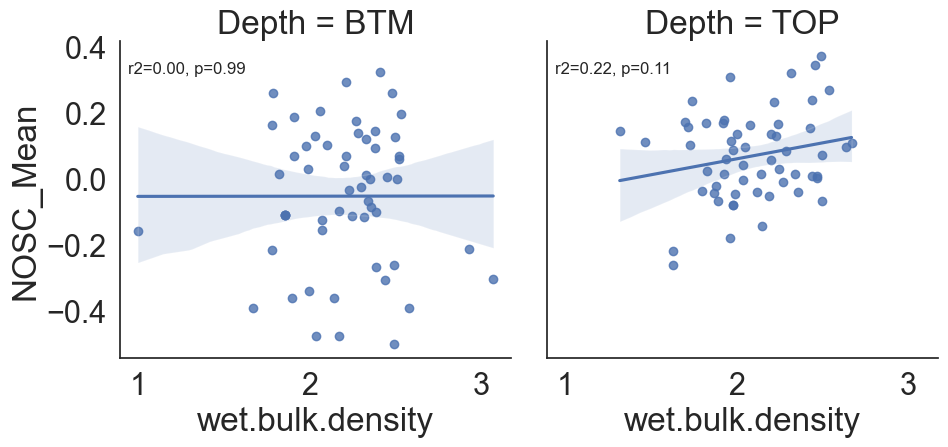

In [93]:
#need to remove nan values to calculate r2 regression 
rmvnan = m[m['wet.bulk.density'].notna()]
g = sns.lmplot(x='wet.bulk.density', y='NOSC_Mean', data=rmvnan, col = 'Depth'
#                height=5, aspect=1
              )

def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['wet.bulk.density'], data['NOSC_Mean'])
    ax = plt.gca()
    ax.text(.02, .9, 'r2={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes, fontsize=12)
    
g.map_dataframe(annotate)
plt.show()

### Export the results

In [181]:
# save selected figures
ax.savefig('NOSC_Mean_wetbulkdensity.png')

In [ ]:
# export modified dataframes
df.to_csv(outputdir+'FTICRMS_CalculatedProperties.csv')
m.to_csv(outputdir+'FTICRMS_Summary.csv')